# Forecasting Solar Energy Generation in Germany

## Table of Contents

* [1. Exploratory Data Analysis](#eda)
    * [1.1. Downloading data](#download)
    * [1.2. Data Exploration](#exploration)
    * [1.3. Creating the German dataset](#german)
    * [1.4. Plots for the daily German dataset](#german_plots)

* [2. Theory and functions for ARIMA models](#arima)
    * [2.0. Box-Jenkins method](#box)
    * [2.1. Identification](#identification)
        * [2.1.1. ADF test](#adf)
        * [2.1.2. ACF and PACF](#acf)
    * [2.2. Estimation](#estimation)
        * [2.2.1. AIC and BIC](#aic)
        * [2.2.2. PACF/ACF for different model](#pacf)
    * [2.3. Model diagnostics](#diagnostics)
    * [2.4. Forecasting](#forecasting)

* [3. Time Series Analysis for WEEKLY Solar Generation in Germany](#ts0)

----

* [3. Time Series Analysis for Solar Generation in Germany](#ts1)

* [4. Time Series Analysis for rolling mean of Solar Generation in Germany (30 days)](#ts2)

* [5. WEEKLY TS](#ts3)

* [5. (!!!) Seasonal TS](#seasonal)

* [The End](#final)



In [1]:
import opendatasets as od
import re
import os

from datetime import datetime
from datetime import timezone
from datetime import date

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')


<a id="eda"></a>

# 1. Exploratory Data Analysis


<a id="download"></a>

## 1.1. Downloading data

Sourse: https://data.open-power-system-data.org/time_series/2020-10-06

"This data package contains different kinds of timeseries data relevant for power system modelling, 
namely electricity prices, electricity consumption (load) as well as wind and solar power generation 
and capacities. The data is aggregated either by country, control area or bidding zone. Geographical 
coverage includes the EU and some neighbouring countries. All variables are provided in hourly 
resolution. Where original data is available in higher resolution (half-hourly or quarter-hourly), 
it is provided in separate files. This package version only contains data provided by TSOs and power 
exchanges via ENTSO-E Transparency, covering the period 2015-mid 2020. See previous versions for 
historical data from a broader range of sources. All data processing is conducted in Python/pandas 
and has been documented in the Jupyter notebooks linked below."

In [2]:
opsd_url = 'https://data.open-power-system-data.org/time_series/2020-10-06/time_series_60min_singleindex.csv'

od.download(opsd_url)

130342912it [00:51, 2524469.69it/s]                                             


In [6]:
# import zipfile

# path_to_zip_file = 'opsd-time_series-2020-10-06.zip'
# directory_to_extract_to = 'opsd-time_series-2020-10-06/'

# with zipfile.ZipFile(path_to_zip_file, 'r') as zip_ref:
#     zip_ref.extractall(directory_to_extract_to)

In [6]:
path_to_csv = 'time_series_60min_singleindex.csv'

df = pd.read_csv(path_to_csv)
df.head()

utc_timestamp        cet_cest_timestamp  \
0  2014-12-31T23:00:00Z  2015-01-01T00:00:00+0100   
1  2015-01-01T00:00:00Z  2015-01-01T01:00:00+0100   
2  2015-01-01T01:00:00Z  2015-01-01T02:00:00+0100   
3  2015-01-01T02:00:00Z  2015-01-01T03:00:00+0100   
4  2015-01-01T03:00:00Z  2015-01-01T04:00:00+0100   

   AT_load_actual_entsoe_transparency  AT_load_forecast_entsoe_transparency  \
0                                 NaN                                   NaN   
1                              5946.0                                6701.0   
2                              5726.0                                6593.0   
3                              5347.0                                6482.0   
4                              5249.0                                6454.0   

   AT_price_day_ahead  AT_solar_generation_actual  \
0                 NaN                         NaN   
1                35.0                         NaN   
2                45.0                         NaN   
3                41.0                         NaN   
4                38.0                         NaN   

   AT_wind_onshore_generation_actual  BE_load_actual_entsoe_transparency  \
0                                NaN                                 NaN   
1                               69.0                              9484.0   
2                               64.0                              9152.0   
3                               65.0                              8799.0   
4                               64.0                              8567.0   

   BE_load_forecast_entsoe_transparency  BE_solar_generation_actual  ...  \
0                                   NaN                         NaN  ...   
1                                9897.0                         NaN  ...   
2                                9521.0                         NaN  ...   
3                                9135.0                         NaN  ...   
4                                8909.0                         NaN  ...   

   SI_load_actual_entsoe_transparency  SI_load_forecast_entsoe_transparency  \
0                                 NaN                                   NaN   
1                                 NaN                                   NaN   
2                             1045.47                                 816.0   
3                             1004.79                                 805.0   
4                              983.79                                 803.0   

   SI_solar_generation_actual  SI_wind_onshore_generation_actual  \
0                         NaN                                NaN   
1                         NaN                                NaN   
2                         NaN                               1.17   
3                         NaN                               1.04   
4                         NaN                               1.61   

   SK_load_actual_entsoe_transparency  SK_load_forecast_entsoe_transparency  \
0                                 NaN                                   NaN   
1                                 NaN                                   NaN   
2                              2728.0                                2860.0   
3                              2626.0                                2810.0   
4                              2618.0                                2780.0   

   SK_solar_generation_actual  SK_wind_onshore_generation_actual  \
0                         NaN                                NaN   
1                         NaN                                NaN   
2                         3.8                                NaN   
3                         3.8                                NaN   
4                         3.8                                NaN   

   UA_load_actual_entsoe_transparency  UA_load_forecast_entsoe_transparency  
0                                 NaN                                   NaN  
1                                 NaN                      

<a id="exploration"></a>

## 1.2. Exploration

In [4]:
df.dtypes

utc_timestamp                            object
cet_cest_timestamp                       object
AT_load_actual_entsoe_transparency      float64
AT_load_forecast_entsoe_transparency    float64
AT_price_day_ahead                      float64
                                         ...   
SK_load_forecast_entsoe_transparency    float64
SK_solar_generation_actual              float64
SK_wind_onshore_generation_actual       float64
UA_load_actual_entsoe_transparency      float64
UA_load_forecast_entsoe_transparency    float64
Length: 300, dtype: object

In [5]:
df.isnull().sum()

utc_timestamp                               0
cet_cest_timestamp                          0
AT_load_actual_entsoe_transparency          1
AT_load_forecast_entsoe_transparency        1
AT_price_day_ahead                      17556
                                        ...  
SK_load_forecast_entsoe_transparency        3
SK_solar_generation_actual                391
SK_wind_onshore_generation_actual       40722
UA_load_actual_entsoe_transparency      24766
UA_load_forecast_entsoe_transparency    24988
Length: 300, dtype: int64

In [77]:
# removing the big dataset

os.remove(path_to_csv)

<a id="german"></a>

## 1.3. Creating the German dataset

In [7]:
german_columns = [col for col in list(df) 
                  if re.search('DE_', col) 
                  and not re.search('DE_LU_', col)
                  and not re.search('_amprion_', col)
                  and not re.search('_tennet_', col)
                  and not re.search('_transnetbw_', col)
                  and not re.search('_50hertz_', col)
                 ]
german_columns

['DE_load_actual_entsoe_transparency',
 'DE_load_forecast_entsoe_transparency',
 'DE_solar_capacity',
 'DE_solar_generation_actual',
 'DE_solar_profile',
 'DE_wind_capacity',
 'DE_wind_generation_actual',
 'DE_wind_profile',
 'DE_wind_offshore_capacity',
 'DE_wind_offshore_generation_actual',
 'DE_wind_offshore_profile',
 'DE_wind_onshore_capacity',
 'DE_wind_onshore_generation_actual',
 'DE_wind_onshore_profile']

* DE_load_actual_entsoe_transparency
    - Description: Total load in Germany in MW as published on ENTSO-E Transparency Platform
* DE_load_forecast_entsoe_transparency
    - Description: Day-ahead load forecast in Germany in MW as published on ENTSO-E Transparency Platform


* DE_solar_capacity
    - Description: Electrical capacity of solar in Germany in MW
* DE_solar_generation_actual
    - Description: Actual solar generation in Germany in MW
* DE_solar_profile
    - Description: Share of solar capacity producing in Germany


* DE_wind_capacity
    - Description: Electrical capacity of wind in Germany in MW
* DE_wind_generation_actual
    - Description: Actual wind generation in Germany in MW
* DE_wind_profile
    - Description: Share of wind capacity producing in Germany


* DE_wind_offshore_capacity
    - Description: Electrical capacity of wind_offshore in Germany in MW
* DE_wind_offshore_generation_actual
    - Description: Actual wind_offshore generation in Germany in MW
* DE_wind_offshore_profile
    - Description: Share of wind_offshore capacity producing in Germany


* DE_wind_onshore_capacity
    - Description: Electrical capacity of wind_onshore in Germany in MW
* DE_wind_onshore_generation_actual
    - Description: Actual wind_onshore generation in Germany in MW
* DE_wind_onshore_profile
    - Description: Share of wind_onshore capacity producing in Germany


in MW == in megawatt

DE_wind_capacity == DE_wind_offshore_capacity + DE_wind_onshore_capacity

XXX_profile == XXX_generation_actual / XXX_capacity 
    for XXX in [DE_solar, DE_wind, DE_wind_offshore, DE_wind_onshore]

XXX_generation_actual == generation for last hour


What is **wind_offshore** and **wind_onshore**?

- **Offshore wind** farms generate electricity from wind blowing across the sea. They are considered more efficient than onshore wind farms, thanks to the higher speed of winds, greater consistency and lack of physical interference that the land or human-made objects can present.

- **Onshore wind** energy is the power that’s generated by wind turbines located on land driven by the natural movement of the air. You’ll often see onshore wind farms in fields or more rural areas, as they’re usually constructed in less-populated areas where buildings and obstacles don’t interrupt the air.

Link: https://www.nationalgrid.com/stories/energy-explained/onshore-vs-offshore-wind-energy#


In [8]:
ger_df = df[['cet_cest_timestamp'] + german_columns]
ger_df.head()

cet_cest_timestamp  DE_load_actual_entsoe_transparency  \
0  2015-01-01T00:00:00+0100                                 NaN   
1  2015-01-01T01:00:00+0100                             41151.0   
2  2015-01-01T02:00:00+0100                             40135.0   
3  2015-01-01T03:00:00+0100                             39106.0   
4  2015-01-01T04:00:00+0100                             38765.0   

   DE_load_forecast_entsoe_transparency  DE_solar_capacity  \
0                                   NaN            37248.0   
1                               39723.0            37248.0   
2                               38813.0            37248.0   
3                               38490.0            37248.0   
4                               38644.0            37248.0   

   DE_solar_generation_actual  DE_solar_profile  DE_wind_capacity  \
0                         NaN               NaN           27913.0   
1                         NaN               NaN           27913.0   
2                         NaN               NaN           27913.0   
3                         NaN               NaN           27913.0   
4                         NaN               NaN           27913.0   

   DE_wind_generation_actual  DE_wind_profile  DE_wind_offshore_capacity  \
0                        NaN              NaN                      667.0   
1                     8852.0           0.3171                      667.0   
2                     9054.0           0.3244                      667.0   
3                     9070.0           0.3249                      667.0   
4                     9163.0           0.3283                      667.0   

   DE_wind_offshore_generation_actual  DE_wind_offshore_profile  \
0                                 NaN                       NaN   
1                               517.0                    0.7744   
2                               514.0                    0.7710   
3                               518.0                    0.7761   
4                               520.0                    0.7793   

   DE_wind_onshore_capacity  DE_wind_onshore_generation_actual  \
0                   27246.0                                NaN   
1                   27246.0                             8336.0   
2                   27246.0                             8540.0   
3                   27246.0                             8552.0   
4                   27246.0                             8643.0   

   DE_wind_onshore_profile  
0                      NaN  
1                   0.3059  
2                   0.3134  
3                   0.3139  
4                   0.3172

In [90]:
def fix_col_1(col):
    if re.findall('DE_(.*)', col):
        return re.findall('DE_(.*)', col)[0]
    else:
        return col

def fix_col_2(col):
    if re.findall('(.*)_entsoe_transparency', col):
        return re.findall('(.*)_entsoe_transparency', col)[0]
    else:
        return col


de_columns = list(ger_df)

for col in de_columns:
#     print()
#     print(col)
#     print(de_columns)
    ger_df[fix_col_1(fix_col_2(col))] = ger_df[col]
    if col != fix_col_1(fix_col_2(col)):
#         print('Need to delete: ', col)
        ger_df.drop(col, axis=1, inplace=True)

pct_columns = [col for col in list(ger_df2) if re.search('_profile', col)]
ger_df.drop(pct_columns, axis=1, inplace=True)

ger_df.head()

/var/folders/zh/mnvg84rj3_7413ycjzpn5y8r0000gp/T/ipykernel_39052/204307928.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ger_df[fix_col_1(fix_col_2(col))] = ger_df[col]
/var/folders/zh/mnvg84rj3_7413ycjzpn5y8r0000gp/T/ipykernel_39052/204307928.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ger_df.drop(pct_columns, axis=1, inplace=True)


cet_cest_timestamp  load_actual  load_forecast  solar_capacity  \
0  2015-01-01T00:00:00+0100          NaN            NaN         37248.0   
1  2015-01-01T01:00:00+0100      41151.0        39723.0         37248.0   
2  2015-01-01T02:00:00+0100      40135.0        38813.0         37248.0   
3  2015-01-01T03:00:00+0100      39106.0        38490.0         37248.0   
4  2015-01-01T04:00:00+0100      38765.0        38644.0         37248.0   

   solar_generation_actual  wind_capacity  wind_generation_actual  \
0                      NaN        27913.0                     NaN   
1                      NaN        27913.0                  8852.0   
2                      NaN        27913.0                  9054.0   
3                      NaN        27913.0                  9070.0   
4                      NaN        27913.0                  9163.0   

   wind_offshore_capacity  wind_offshore_generation_actual  \
0                   667.0                              NaN   
1                   667.0                            517.0   
2                   667.0                            514.0   
3                   667.0                            518.0   
4                   667.0                            520.0   

   wind_onshore_capacity  wind_onshore_generation_actual  
0                27246.0                             NaN  
1                27246.0                          8336.0  
2                27246.0                          8540.0  
3                27246.0                          8552.0  
4                27246.0                          8643.0

In [91]:
ger_df.shape

(50401, 11)

In [92]:
ger_df.isnull().sum()

cet_cest_timestamp                    0
load_actual                           1
load_forecast                        25
solar_capacity                     6601
solar_generation_actual             104
wind_capacity                      6601
wind_generation_actual               75
wind_offshore_capacity             6601
wind_offshore_generation_actual      75
wind_onshore_capacity              6601
wind_onshore_generation_actual       73
dtype: int64

In [93]:
# saving the original dataset for Germany

ger_df.to_csv('germany_wind_and_solar.csv', sep='\t', encoding='utf-8', index=False)

In [94]:
# create daily column

ger_df2 = ger_df[list(ger_df)]

ger_df2['cet_dttm'] = ger_df2['cet_cest_timestamp'].apply(lambda x: datetime.fromisoformat(x[:-5]))
ger_df2['cet_dt'] = pd.to_datetime(pd.to_datetime(ger_df2['cet_dttm'], utc=True).dt.date)
# monday of this week
ger_df2['cet_week_dt'] = ger_df2['cet_dt'] - pd.to_timedelta(ger_df2['cet_dt'].dt.dayofweek, unit='d')
# first day of this month
ger_df2['cet_month_dt'] = ger_df2['cet_dt'].apply(lambda x: x.replace(day=1))
ger_df2.head()

cet_cest_timestamp  load_actual  load_forecast  solar_capacity  \
0  2015-01-01T00:00:00+0100          NaN            NaN         37248.0   
1  2015-01-01T01:00:00+0100      41151.0        39723.0         37248.0   
2  2015-01-01T02:00:00+0100      40135.0        38813.0         37248.0   
3  2015-01-01T03:00:00+0100      39106.0        38490.0         37248.0   
4  2015-01-01T04:00:00+0100      38765.0        38644.0         37248.0   

   solar_generation_actual  wind_capacity  wind_generation_actual  \
0                      NaN        27913.0                     NaN   
1                      NaN        27913.0                  8852.0   
2                      NaN        27913.0                  9054.0   
3                      NaN        27913.0                  9070.0   
4                      NaN        27913.0                  9163.0   

   wind_offshore_capacity  wind_offshore_generation_actual  \
0                   667.0                              NaN   
1                   667.0                            517.0   
2                   667.0                            514.0   
3                   667.0                            518.0   
4                   667.0                            520.0   

   wind_onshore_capacity  wind_onshore_generation_actual            cet_dttm  \
0                27246.0                             NaN 2015-01-01 00:00:00   
1                27246.0                          8336.0 2015-01-01 01:00:00   
2                27246.0                          8540.0 2015-01-01 02:00:00   
3                27246.0                          8552.0 2015-01-01 03:00:00   
4                27246.0                          8643.0 2015-01-01 04:00:00   

      cet_dt cet_week_dt cet_month_dt  
0 2015-01-01  2014-12-29   2015-01-01  
1 2015-01-01  2014-12-29   2015-01-01  
2 2015-01-01  2014-12-29   2015-01-01  
3 2015-01-01  2014-12-29   2015-01-01  
4 2015-01-01  2014-12-29   2015-01-01

In [95]:
ger_df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50401 entries, 0 to 50400
Data columns (total 15 columns):
 #   Column                           Non-Null Count  Dtype         
---  ------                           --------------  -----         
 0   cet_cest_timestamp               50401 non-null  object        
 1   load_actual                      50400 non-null  float64       
 2   load_forecast                    50376 non-null  float64       
 3   solar_capacity                   43800 non-null  float64       
 4   solar_generation_actual          50297 non-null  float64       
 5   wind_capacity                    43800 non-null  float64       
 6   wind_generation_actual           50326 non-null  float64       
 7   wind_offshore_capacity           43800 non-null  float64       
 8   wind_offshore_generation_actual  50326 non-null  float64       
 9   wind_onshore_capacity            43800 non-null  float64       
 10  wind_onshore_generation_actual   50328 non-null  float64  

In [15]:
ger_df2_h = ger_df2[list(ger_df2)]
ger_df2_h = ger_df2_h.set_index('cet_dttm')
ger_df2_h.head()

cet_cest_timestamp  load_actual  load_forecast  \
cet_dttm                                                                    
2015-01-01 00:00:00  2015-01-01T00:00:00+0100          NaN            NaN   
2015-01-01 01:00:00  2015-01-01T01:00:00+0100      41151.0        39723.0   
2015-01-01 02:00:00  2015-01-01T02:00:00+0100      40135.0        38813.0   
2015-01-01 03:00:00  2015-01-01T03:00:00+0100      39106.0        38490.0   
2015-01-01 04:00:00  2015-01-01T04:00:00+0100      38765.0        38644.0   

                     solar_capacity  solar_generation_actual  solar_profile  \
cet_dttm                                                                      
2015-01-01 00:00:00         37248.0                      NaN            NaN   
2015-01-01 01:00:00         37248.0                      NaN            NaN   
2015-01-01 02:00:00         37248.0                      NaN            NaN   
2015-01-01 03:00:00         37248.0                      NaN            NaN   
2015-01-01 04:00:00         37248.0                      NaN            NaN   

                     wind_capacity  wind_generation_actual  wind_profile  \
cet_dttm                                                                   
2015-01-01 00:00:00        27913.0                     NaN           NaN   
2015-01-01 01:00:00        27913.0                  8852.0        0.3171   
2015-01-01 02:00:00        27913.0                  9054.0        0.3244   
2015-01-01 03:00:00        27913.0                  9070.0        0.3249   
2015-01-01 04:00:00        27913.0                  9163.0        0.3283   

                     wind_offshore_capacity  wind_offshore_generation_actual  \
cet_dttm                                                                       
2015-01-01 00:00:00                   667.0                              NaN   
2015-01-01 01:00:00                   667.0                            517.0   
2015-01-01 02:00:00                   667.0                            514.0   
2015-01-01 03:00:00                   667.0                            518.0   
2015-01-01 04:00:00                   667.0                            520.0   

                     wind_offshore_profile  wind_onshore_capacity  \
cet_dttm                                                            
2015-01-01 00:00:00                    NaN                27246.0   
2015-01-01 01:00:00                 0.7744                27246.0   
2015-01-01 02:00:00                 0.7710                27246.0   
2015-01-01 03:00:00                 0.7761                27246.0   
2015-01-01 04:00:00                 0.7793                27246.0   

                     wind_onshore_generation_actual  wind_onshore_profile  \
cet_dttm                                                                    
2015-01-01 00:00:00                             NaN                   NaN   
2015-01-01 01:00:00                          8336.0                0.3059   
2015-01-01 02:00:00                          8540.0                0.3134   
2015-01-01 03:00:00                          8552.0                0.3139   
2015-01-01 04:00:00                          8643.0                0.3172   

                        cet_dt  
cet_dttm                        
2015-01-01 00:00:00 2015-01-01  
2015-01-01 01:00:00 2015-01-01  
2015-01-01 02:00:00 2015-01-01  
2015-01-01 03:00:00 2015-01-01  
2015-01-01 04:00:00 2015-01-01

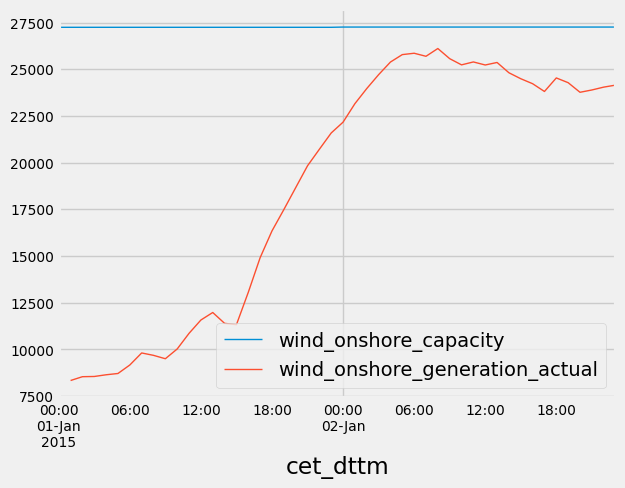

In [16]:
# Plot your the discoveries time series
ax = ger_df2_h['2015-01-01':'2015-01-02'][['wind_onshore_capacity', 'wind_onshore_generation_actual']].plot(fontsize=10, linewidth=1)

# Add a red vertical line
# ax.axvline('2020-01-01', color='red', linestyle='--')

# Add a green horizontal line
# ax.axhline(20000, color='green', linestyle='--')

plt.show()


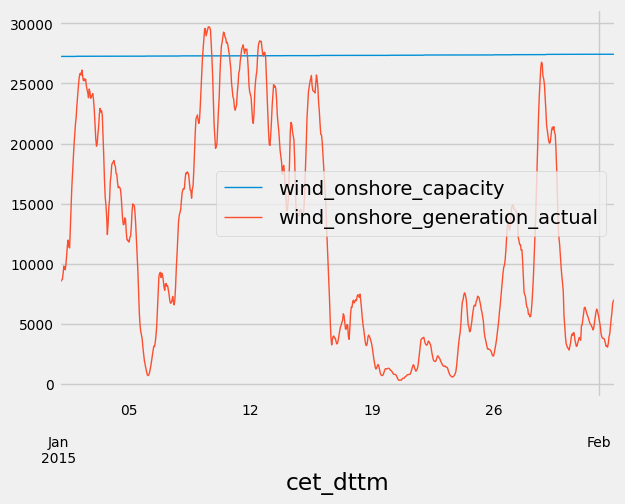

In [17]:
# Plot your the discoveries time series
ax = ger_df2_h['2015-01-01':'2015-02-01'][['wind_onshore_capacity', 'wind_onshore_generation_actual']].plot(fontsize=10, linewidth=1)

# Add a red vertical line
# ax.axvline('2020-01-01', color='red', linestyle='--')

# Add a green horizontal line
# ax.axhline(20000, color='green', linestyle='--')

plt.show()


### 1.3.1. Daily dataset 

In [19]:
ger_daily_generation_df = ger_df2[['cet_dt',
    'solar_generation_actual',
    'wind_generation_actual',
    'wind_offshore_generation_actual','wind_onshore_generation_actual'
]].groupby(['cet_dt']).sum()

ger_daily_generation_df.head(10)

solar_generation_actual  wind_generation_actual  \
cet_dt                                                        
2015-01-01                  17098.0                302693.0   
2015-01-02                   7757.0                601950.0   
2015-01-03                   7237.0                469167.0   
2015-01-04                  19982.0                390566.0   
2015-01-05                  26522.0                227370.0   
2015-01-06                  32888.0                109591.0   
2015-01-07                  17114.0                221294.0   
2015-01-08                   8599.0                432866.0   
2015-01-09                   6822.0                644152.0   
2015-01-10                  20473.0                630566.0   

            wind_offshore_generation_actual  wind_onshore_generation_actual  
cet_dt                                                                       
2015-01-01                          11992.0                        290701.0  
2015-01-02                          10329.0                        591622.0  
2015-01-03                          12120.0                        457046.0  
2015-01-04                          11540.0                        379028.0  
2015-01-05                           7748.0                        219622.0  
2015-01-06                           6887.0                        102704.0  
2015-01-07                          10694.0                        210599.0  
2015-01-08                          12334.0                        420529.0  
2015-01-09                           8803.0                        635350.0  
2015-01-10                           6504.0                        624058.0

In [20]:
ger_daily_generation_df_slice = ger_daily_generation_df['2017':'2020']
ger_daily_generation_df_slice

solar_generation_actual  wind_generation_actual  \
cet_dt                                                        
2017-01-01                  35291.0                310156.0   
2017-01-02                  12479.0                290985.0   
2017-01-03                   9351.0                650021.0   
2017-01-04                  12814.0                699663.0   
2017-01-05                  20797.0                277103.0   
...                             ...                     ...   
2020-09-27                  96856.0                219488.0   
2020-09-28                 111763.0                 79293.0   
2020-09-29                  88967.0                 75793.0   
2020-09-30                 115781.0                105957.0   
2020-10-01                      0.0                 25331.0   

            wind_offshore_generation_actual  wind_onshore_generation_actual  
cet_dt                                                                       
2017-01-01                          51756.0                        258398.0  
2017-01-02                          60886.0                        230100.0  
2017-01-03                          74353.0                        575666.0  
2017-01-04                          70048.0                        629615.0  
2017-01-05                          34279.0                        242823.0  
...                                     ...                             ...  
2020-09-27                          83758.0                        135732.0  
2020-09-28                          21262.0                         58028.0  
2020-09-29                          20280.0                         55517.0  
2020-09-30                          59399.0                         46560.0  
2020-10-01                          10780.0                         14551.0  

[1370 rows x 4 columns]

In [96]:
ger_wind_df_slice = ger_daily_generation_df_slice[['wind_generation_actual']]

# Print out summary statistics
# print(ger_wind_df_slice.describe())
# print()

# print(ger_wind_df_slice.describe().loc['max'])
# print(ger_wind_df_slice.describe().loc['min'])

In [22]:
ger_solar_df_slice = ger_daily_generation_df_slice[['solar_generation_actual']]

# Print out summary statistics
print(ger_solar_df_slice.describe())
# print()

# print(ger_solar_df_slice.describe().loc['max'])
# print(ger_solar_df_slice.describe().loc['min'])

       solar_generation_actual
count              1370.000000
mean             117144.535766
std               72968.444844
min                   0.000000
25%               47188.250000
50%              116462.000000
75%              177396.500000
max              290429.000000


### 1.3.2. Weekly dataset 

In [97]:
ger_weekly_generation_df = ger_df2[['cet_week_dt',
    'solar_generation_actual',
    'wind_generation_actual',
    'wind_offshore_generation_actual','wind_onshore_generation_actual'
]].groupby(['cet_week_dt']).sum()

ger_weekly_generation_df.head(10)

solar_generation_actual  wind_generation_actual  \
cet_week_dt                                                    
2014-12-29                   52074.0               1764376.0   
2015-01-05                  132229.0               2895813.0   
2015-01-12                  172051.0               2642826.0   
2015-01-19                   97130.0                468323.0   
2015-01-26                  130888.0               1683353.0   
2015-02-02                  254387.0               1311524.0   
2015-02-09                  300430.0               1001276.0   
2015-02-16                  385706.0               1404748.0   
2015-02-23                  359899.0               1765579.0   
2015-03-02                  620977.0               2103152.0   

             wind_offshore_generation_actual  wind_onshore_generation_actual  
cet_week_dt                                                                   
2014-12-29                           45981.0                       1718397.0  
2015-01-05                           62520.0                       2833286.0  
2015-01-12                           69014.0                       2573810.0  
2015-01-19                           30111.0                        438209.0  
2015-01-26                           59824.0                       1623530.0  
2015-02-02                           55712.0                       1255809.0  
2015-02-09                           65459.0                        935818.0  
2015-02-16                           81511.0                       1323237.0  
2015-02-23                           93694.0                       1671877.0  
2015-03-02                          119154.0                       1983999.0

In [99]:
ger_weekly_generation_df.shape

(301, 4)

### 1.3.3. Monthly dataset 

In [98]:
ger_monthly_generation_df = ger_df2[['cet_month_dt',
    'solar_generation_actual',
    'wind_generation_actual',
    'wind_offshore_generation_actual','wind_onshore_generation_actual'
]].groupby(['cet_month_dt']).sum()

ger_monthly_generation_df.head(10)

solar_generation_actual  wind_generation_actual  \
cet_month_dt                                                    
2015-01-01                   559692.0               9334624.0   
2015-02-01                  1288413.0               5148466.0   
2015-03-01                  2858576.0               6923411.0   
2015-04-01                  4435384.0               5002872.0   
2015-05-01                  4411604.0               5262785.0   
2015-06-01                  4552821.0               4095101.0   
2015-07-01                  4917511.0               5863167.0   
2015-08-01                  4612575.0               3858013.0   
2015-09-01                  3226533.0               5547629.0   
2015-10-01                  1946347.0               3983075.0   

              wind_offshore_generation_actual  wind_onshore_generation_actual  
cet_month_dt                                                                   
2015-01-01                           261446.0                       9073168.0  
2015-02-01                           282754.0                       4865705.0  
2015-03-01                           431976.0                       6491432.0  
2015-04-01                           378485.0                       4624380.0  
2015-05-01                           565139.0                       4697640.0  
2015-06-01                           481563.0                       3613528.0  
2015-07-01                           707917.0                       5155259.0  
2015-08-01                           570967.0                       3287053.0  
2015-09-01                           768406.0                       4779224.0  
2015-10-01                           888197.0                       3094875.0

In [100]:
ger_monthly_generation_df.shape

(70, 4)

<a id="german_plots"></a>

## 1.4. Plots for the daily German dataset

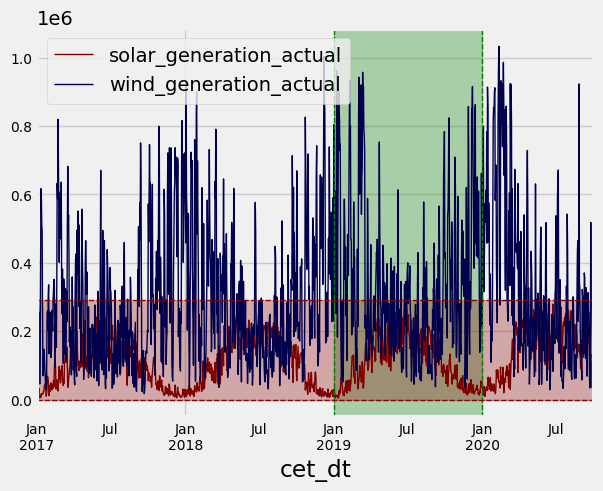

In [23]:

ax = ger_daily_generation_df_slice[[
    'solar_generation_actual','wind_generation_actual'
]].plot(fontsize=10, linewidth=1, colormap='seismic_r') # color='blue'


# Add vertical lines
ax.axvline('2019-01-01', color='green', linestyle='--', linewidth=1)
ax.axvline('2020-01-01', color='green', linestyle='--', linewidth=1)

# Add a vertical red shaded region
ax.axvspan('2019-01-01', '2020-01-01', color='green', alpha=0.3)


solar_max = ger_daily_generation_df_slice['solar_generation_actual'].max()
solar_min = ger_daily_generation_df_slice['solar_generation_actual'].min()

# Add a green horizontal line
ax.axhline(solar_max, color='darkred', linestyle='--', linewidth=1)
ax.axhline(solar_min, color='darkred', linestyle='--', linewidth=1)

# Add a horizontal green shaded region
ax.axhspan(solar_min, solar_max, color='darkred', alpha=0.3)

plt.show()

In [24]:
def plot_rolling_mean_std(df, column, window_size):
    
    # Compute the 52 weeks rolling mean and rolling standard deviation of the wind_generation_actual
    ma = df[[column]].rolling(window=window_size).mean()
    mstd = df[[column]].rolling(window=window_size).std()

    # Add the upper and lower bound columns to the ma DataFrame
    ma['upper'] = ma[column] + (2 * mstd[column])
    ma['lower'] = ma[column] - (2 * mstd[column])
    
    fig, ax = plt.subplots(figsize = (8,6))

    c = sns.lineplot(data = ma, ax=ax, linewidth=1)
    line = c.get_lines()
    plt.fill_between(line[0].get_xdata(), line[1].get_ydata(), line[2].get_ydata(), color='darkblue', alpha=.2)

    ax.set_xlabel('Date', fontsize=10)
    ax.set_ylabel(column, fontsize=10)
    ax.set_title(f'Rolling mean and variance of {column}\nin Germany from 2018 to 2020'.format(column=column), fontsize=10)
    plt.xticks(rotation = 45, size=10)
    plt.yticks(size=10)
    plt.legend(fontsize="10")

    plt.show()

    return 1


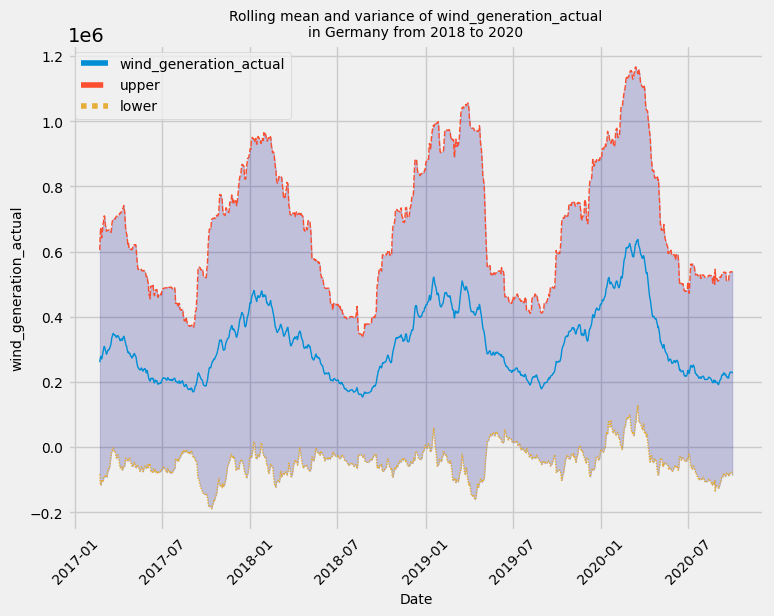

1

In [25]:
plot_rolling_mean_std(ger_daily_generation_df_slice, 'wind_generation_actual', window_size=52)


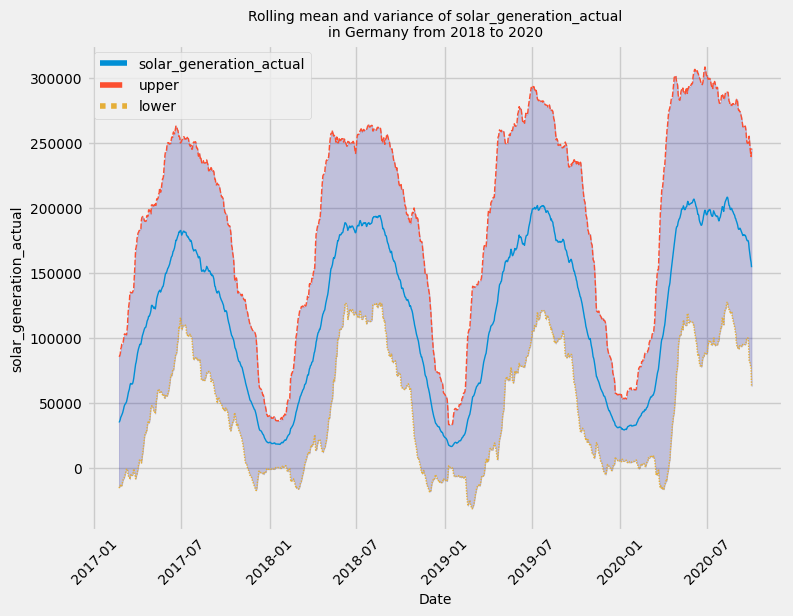

1

In [26]:
plot_rolling_mean_std(ger_daily_generation_df_slice, 'solar_generation_actual', window_size=52)


In [27]:
def plot_by_month(df):

    index_month = df.index.month
    mean_df_by_month = df.groupby(index_month).mean()

    ax = mean_df_by_month.plot(fontsize=6, linewidth=1)

    plt.legend(fontsize=10)
    plt.show()
    
    return 1

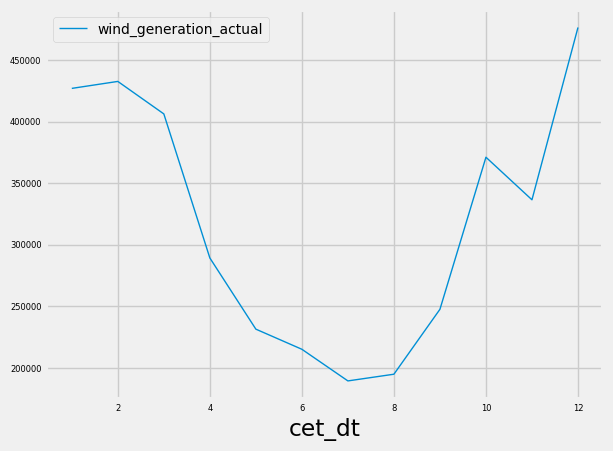

1

In [28]:
plot_by_month(ger_daily_generation_df_slice[['wind_generation_actual']])

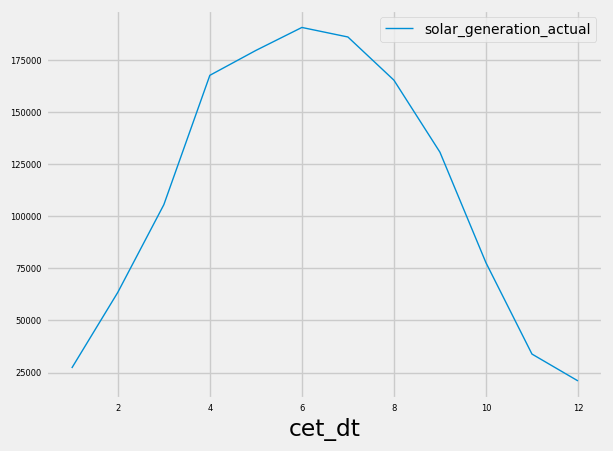

1

In [29]:
plot_by_month(ger_daily_generation_df_slice[['solar_generation_actual']])

### Histograms

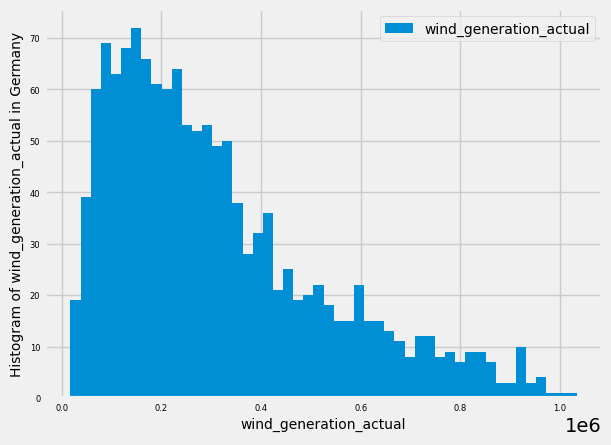

In [30]:
# Generate a histogram
ax = ger_daily_generation_df_slice[['wind_generation_actual']].plot(kind='hist', bins=50, fontsize=6)

# Set the labels and display the plot
ax.set_xlabel('wind_generation_actual', fontsize=10)
ax.set_ylabel('Histogram of wind_generation_actual in Germany', fontsize=10)
plt.legend(fontsize=10)
plt.show()

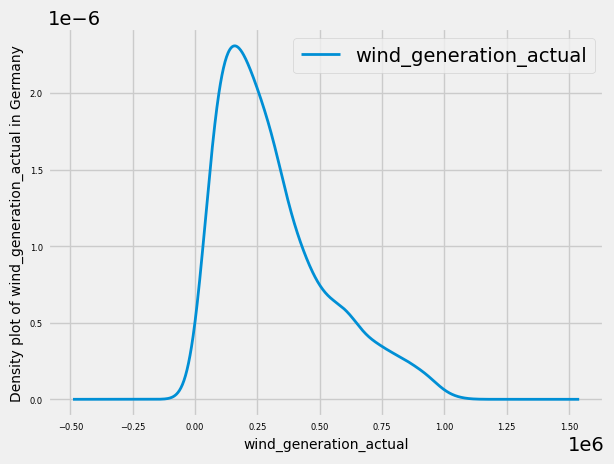

In [31]:
# Display density plot
ax = ger_daily_generation_df_slice[['wind_generation_actual']].plot(kind='density', linewidth=2, fontsize=6)

# Annotate labels
ax.set_xlabel('wind_generation_actual', fontsize=10)
ax.set_ylabel('Density plot of wind_generation_actual in Germany', fontsize=10)
plt.show()

### MULTIPLE TS

In [32]:
ger_wind_solar_df = ger_daily_generation_df[list(ger_daily_generation_df)][['wind_generation_actual', 'solar_generation_actual']]
ger_wind_solar_df_slice = ger_wind_solar_df['2017':'2020']


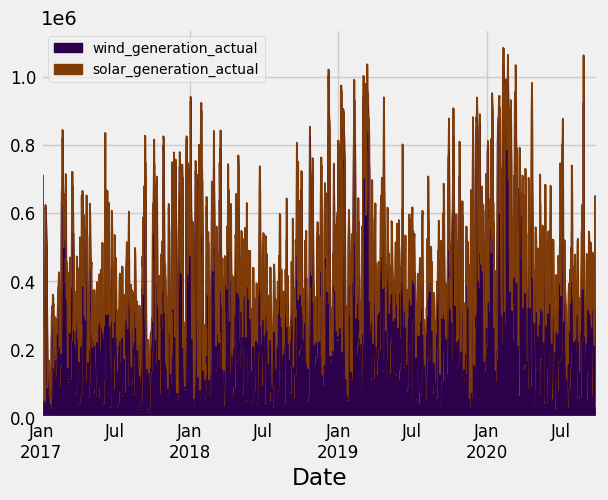

In [33]:
# Plot a STACKED area chart
ax = ger_daily_generation_df_slice[['wind_generation_actual', 'solar_generation_actual']].plot.area(colormap='PuOr_r', fontsize=12, linewidth=1, stacked=True) # , stacked=False

ax.set_xlabel('Date')
ax.legend(fontsize=10)
plt.show()

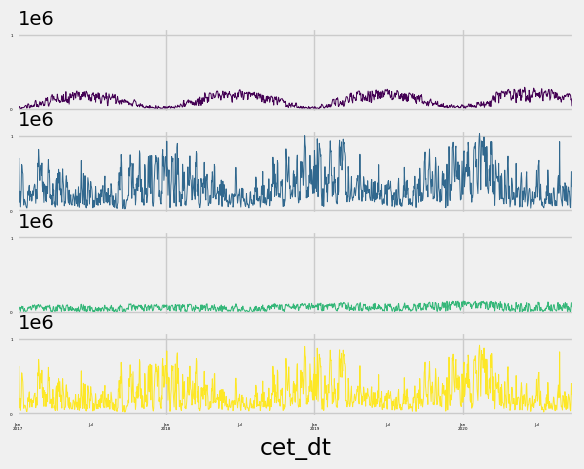

In [34]:
# Create a facetted graph with 4 rows and 1 columns
ax = ger_daily_generation_df_slice.plot(subplots=True,
                      layout=(4,1),
                      sharex=True,
                      sharey=True,
                      colormap='viridis', 
                      linewidth=0.7,
                      fontsize=3,
                      legend=False)

plt.show()

### CORRELATIONS

In [35]:
print(ger_daily_generation_df_slice[['wind_generation_actual', 'solar_generation_actual']].corr(method='pearson'))


                         wind_generation_actual  solar_generation_actual
wind_generation_actual                 1.000000                -0.427539
solar_generation_actual               -0.427539                 1.000000


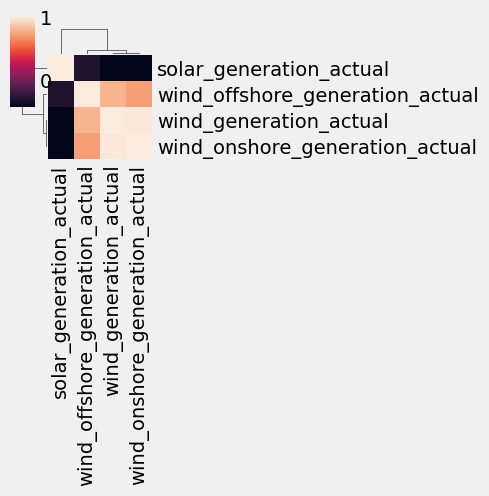

In [36]:
# Get correlation matrix
corr_wind_solar = ger_daily_generation_df_slice.corr(method='pearson')

fig = sns.clustermap(corr_wind_solar,
                     row_cluster=True,
                     col_cluster=True,
                     figsize=(5, 5))
plt.setp(fig.ax_heatmap.xaxis.get_majorticklabels(), rotation=90)
plt.setp(fig.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)
plt.show()

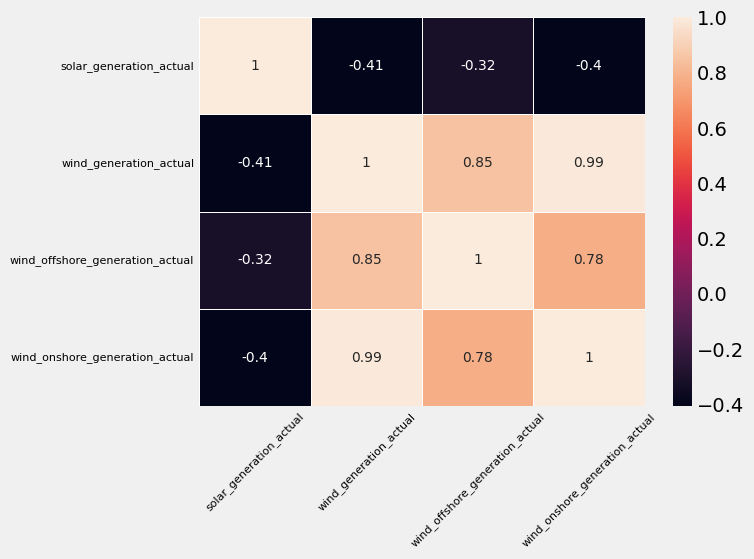

In [37]:
# Get correlation matrix
corr_wind_solar = ger_daily_generation_df_slice.corr(method='spearman')

sns.heatmap(corr_wind_solar,
            annot=True,
            linewidths=0.4,
            annot_kws={"size": 10})
plt.xticks(rotation=45, fontsize=8)
plt.yticks(rotation=0, fontsize=8) 
plt.show()

In [385]:
# ger_daily_generation_df_slice[['wind_generation_actual', 'solar_generation_actual']]

<a id="arima"></a>

# 2. Theory and functions for ARIMA models

In [176]:
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX


<a id="box"></a>

## 2.0. Box-Jenkins method

**ARIMA** model:

- **AR** = autoregressive

- **I** = integrated

- **MA** = moving average

order=(p,d,q):

- p - number of autoregressive lags
- d - order of differencing
- q - number of moving average lags

The **Auto-Regressive (AR) model** assumes that the current value (y_t) is *dependent on previous values* (y_(t-1), y_(t-2), …). Because of this assumption, we can build a linear regression model. To figure out the order of an AR model, you need to look at the **PACF**.

The **Moving Average (MA) model** assumes that the current value (y_t) is *dependent on the error terms including the current error* (𝜖_t, 𝜖_(t-1),…). Because error terms are random, there’s no linear relationship between the current value and the error terms. To figure out the order of an MA model, you need to look at the **ACF**.

Link: https://towardsdatascience.com/interpreting-acf-and-pacf-plots-for-time-series-forecasting-af0d6db4061c

Steps of the **Box-Jenkins method**:

- 1. Identification *(Is the time series stationary? What dierencing/transform will make it stationary?)*
    - Run Dicky-Fuller test
    - See ADF statistic and p-value
    - Plot ACF and PACF
    - Finally choose d
- 2. Estimation *(What values of p and q are most promising?)*
    - Loop over p and q values for ARIMA(p,d,q) to choose p, q.
- 3. Diagnostics
    - Plot 4 diagostics plots
    - See summary
- 4. Decision
    - Is the model ok?
        - If no, repeat 1-3.
        - If yes, see 5.
- 5. Production
    - results.get_forecast()

In [172]:
def plot_seasonal_components(ts, period):
    
    decomp_weekly = seasonal_decompose(ts, period=period)

    fig, axes = plt.subplots(4, 1, sharex=True)

    decomp_weekly.observed.plot(ax=axes[0], legend=False, color='r', linewidth=1)
    axes[0].set_ylabel('Observed', fontsize=12)

    decomp_weekly.trend.plot(ax=axes[1], legend=False, color='g', linewidth=1)
    axes[1].set_ylabel('Trend', fontsize=12)

    decomp_weekly.seasonal.plot(ax=axes[2], legend=False, linewidth=1)
    axes[2].set_ylabel('Seasonal', fontsize=12)

    decomp_weekly.resid.plot(ax=axes[3], legend=False, color='k', linewidth=1)
    axes[3].set_ylabel('Residual', fontsize=12)
    
    return 1

In [182]:
def obtain_adf_kpss_results(ts, max_d):
    """ Build dataframe with ADF statistics and p-value for time series after applying difference on time series
    
    Args:
        ts (df): Dataframe of univariate time series  
        max_d (int): Max value of how many times apply difference
        
    Returns:
        Dataframe showing values of ADF statistics and p when applying ADF test after applying d times 
        differencing on a time-series.
    
    """
    
    results = []

    for idx in range(max_d):
        adf_result = adfuller(ts, autolag='AIC')
        kpss_result = kpss(ts, regression='c', nlags="auto")
        
        if adf_result[1] <= 0.05:
            adf_stationary = True
        else:
            adf_stationary = False
            
        if kpss_result[1] <= 0.05:
            kpss_stationary = False
        else:
            kpss_stationary = True
            
        stationary = adf_stationary & kpss_stationary
        results.append((idx, adf_result[1], kpss_result[1], adf_stationary, kpss_stationary, stationary))
        ts = ts.diff().dropna() # counter of differencing
    
    # Construct DataFrame 
    results_df = pd.DataFrame(results, columns=['d', 'adf_stats', 'p-value', 'is_adf_stationary', 'is_kpss_stationary', 'is_stationary' ])
    
    return results_df

# Link: https://github.com/MKB-Datalab/time-series-analysis-with-SARIMAX-and-Prophet/blob/master/notebooks/01-Intro_time_series_tutorial.ipynb


<a id="identification"></a>

## 2.1. Identification

<a id="adf"></a>

### 2.1.1. ADF test

AFD test = Augmented Dicky-Fuller test.

This is test for **stationarity**.

- If the time series is stationary, try to fit the ARMA model
- If the time series is non-stationary, seek the value of d. 

https://analyticsindiamag.com/quick-way-to-find-p-d-and-q-values-for-arima/

+

ADF-test statistic
- More negative means more likely to be stationary

p-value
- If small, reject the null hypothesis - reject non-stationarity

In [39]:
def run_adf_test(ts, diff_order):
    '''
    diff_order = 0, 1, 2
    '''
    
    if diff_order == 0:
        ts0 = ts.dropna()
    elif diff_order == 1:
        ts0 = ts.dropna().diff().dropna()
    elif diff_order == 2:
        ts0 = ts.dropna().diff().dropna().diff().dropna()
    else:
        ts0 = ts.dropna()
        
    result = adfuller(ts0)
    
    fig, ax = plt.subplots()
    ts0.plot(ax=ax, linewidth=1)
    plt.show()

    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    print('Critical values:', result[4])

    return 1

<a id="acf"></a>

### 2.1.2. ACF and PACF

- **ACF** - autocorrelation function

- **PACF** - partial autocorrelation function


Using ACF and PACF **to choose model order**.

The ACF plot can provide answers to the following questions:

- Is the observed time series white noise/random?
- Is an observation related to an adjacent observation, an observation twice-removed, and so on?
- Can the observed time series be modeled with an MA model? If yes, what is the order?

link: https://towardsdatascience.com/interpreting-acf-and-pacf-plots-for-time-series-forecasting-af0d6db4061c

In [40]:
def plot_acf_functions(ts, lags):
    
    fig, (ax1, ax2, ax3) = plt.subplots(3, sharex=True)
    plot_acf(ts.dropna(), lags=lags, ax=ax1)
    plot_acf(ts.dropna().diff().dropna(), lags=lags, ax=ax2)
    plot_acf(ts.dropna().diff().dropna().diff().dropna(), lags=lags, ax=ax3)
    plt.show()

    return 1

<a id="estimation"></a>

## 2.2. Estimation

There are 2 ways to choose optimal p and q: 
- PACF/ACF plots
- Information crateria (AIC/BIC)

<a id="aic"></a>

### 2.2.1. AIC and BIC

- **AIC** - Akaike information criterion
    - lower AIC indicates a better model

- **BIC** - Bayesian information criterion
    - lower BIC indicates a better model

The **AIC** tries to select the model that most adequately describes an unknown, high dimensional reality. This means that reality is never in the set of candidate models that are being considered. 

On the contrary, **BIC** tries to find the TRUE model among the set of candidates. I find it quite odd the assumption that reality is instantiated in one of the models that the researchers built along the way. This is a real issue for BIC.

Link: https://stats.stackexchange.com/questions/577/is-there-any-reason-to-prefer-the-aic-or-bic-over-the-other

We should choose p,q for minimal AIC/BIC.

In [ ]:
def sort_aic_bic(ts, d, max_p, max_q):
    
    order_aic_bic = []

    for p in range(max_p):
        for q in range(max_q):
            try:
                model = ARIMA(ts, order=(p,d,q))
                results = model.fit()
                order_aic_bic.append((p, q, results.aic, results.bic))
            except:
                order_aic_bic.append((p, q, None, None))
                
    order_df = pd.DataFrame(order_aic_bic, columns=['p', 'q', 'AIC', 'BIC'])

    print("Sorting by AIC:")
    print(order_df.sort_values('AIC')[:20])
    print()
    print("Sorting by BIC:")
    print(order_df.sort_values('BIC')[:20])
    
    return 1


<a id="pacf"></a>

### 2.2.2. PACF/ACF for different model

- **Autocorrelation** is the correlation between a time series with a lagged version of itself. 
    - The ACF starts at a lag of 0, which is the correlation of the time series with itself and therefore results in a correlation of 1.
    
- The **partial autocorrelation at lag k** is the autocorrelation between X_t_t and X_(t-k) that is not accounted for by lags 1 through 𝑘−1.



Additionally, you can see a *blue area in the ACF and PACF plots*. This blue area depicts the 95% confidence interval and is an indicator of the significance threshold. That means: 
- anything within the blue area is statistically close to zero and 
- anything outside the blue area is statistically non-zero.

To determine the order of the model, you check: “**How many lollipops are above or below the confidence interval before the next lollipop enters the blue area?**”.

Link: https://towardsdatascience.com/interpreting-acf-and-pacf-plots-for-time-series-forecasting-af0d6db4061c

    
- Using the **PACF plot** we can take the order of AR terms to be equal to the lags that can cross a significance limit. 
    - For example: *Here we can see that the first lag is significantly out of the limit and the second one is also out of the significant limit but it is not that far so we can select the order of the **p** as 1.*


- To find out the value of **q** we can use the **ACF plot**. Which will tell us how much moving average is required to remove the autocorrelation from the stationary time series. 
    - For example: *Here we can see that 2 of the lags are out of the significance limit so we can say that the optimal value of our q (MA) is 2.*

In [188]:
def plot_acf_pacf(ts, lags):

    fig, (ax1, ax2) = plt.subplots(2,1, figsize=(12,8))

#     for q
    plot_acf(ts.dropna(), lags=lags, zero=False, ax=ax1) # .diff().dropna()
#     for p
    plot_pacf(ts.dropna(), lags=lags, zero=False, ax=ax2) # .diff().dropna()

    plt.show()

    return 1

After that, we can choose **p** and **q** for ARIMA model.

<a id="diagnostics"></a>

## 2.3. Model diagnostics

If the model fits well, the **residuals** will be *white Gaussian noise*.

In [43]:
def arima_diagnostics(ts, p,d,q):

    model = ARIMA(ts, order=(p,d,q))
    results = model.fit()

    mae = np.mean(np.abs(results.resid))
    print("Mean absolute error from residuals:", mae)
    print()

    # summary
    print(results.summary())

    # 4 diagnostics plots
    results.plot_diagnostics(figsize=(15,12))
    plt.show()
    
    return results

**Prob(Q)** = p-value for null hypothesis that residuals are uncorrelated

- **Prob(Q)** is larger than 0.05. We shouldn't reject the null that the residuals are uncorrelated.
- **Prob(Q)** is smaller than 0.05. We should reject the null that the residuals are uncorrelated.


**Prob(JB)** = p-value for null hypothesis that residuals are normal

- **Prob(JB)** is not less than 0.05. We shouldn't reject the null that the residuals are normally distributed.
- **Prob(JB)** is less than 0.05. We should reject the null that the residuals are normally distributed.


For an *ideal model* the **residuals should be uncorrelated with Gaussian noise centered on zero**. By analyzing the plots above having this in mind we can evaluate if we have a good model or not.

- **Standardized residual**. 
    - For a good model: There are *no obvious patterns* in the residuals.
- **Histogram plus kde** estimate: The histogram shows the measured distribution of the residuals while the orange line shows the KDE curve (smoothed version of the histogram). The green line shows a normal distribution. 
    - For a good model *the orange line should be similar to the green line*.
- **Correlogram** or **ACF plot**: 
    - For a good model: *95% of correlations for lag greater than one* should not be significant (*inside the blue area*).
- **Normal Q-Q**: 
    - For a good model: *Most of the data points should lie on the straight line*, indicating a normal distribution of the residuals.

<!-- Therefore, all in all the model pointed by our empirical search seems to be a good model. -->

Link: https://www.jadsmkbdatalab.nl/forecasting-with-sarimax-models/

<a id="seasonal"></a>

## 2.4. Seasonal

Previously, we got a hint from the ACF plot that our time series has a **seasonal period** of N. (**S**)

### Seasonal Differencing (D)

For a seasonal time series, we may need to apply seasonal differencing. In seasonal differencing, instead of substracting the most recent time series value, we subtract the time series value from one cycle ago. Therefore, if the time series shows a trend, then we take the normal difference. If there is a strong seasonal cycle, then we will also take the seasonal difference.
 
Furthermore, in the case of strong seasonality, as observed in our time series, D=1. A rule of thumb is that **d + D should not be greater than 2**.

### P, Q

In [140]:
def sarima_diagnostics(ts, p,d,q, P,D,Q,S):

    model = ARIMA(ts, order=(p,d,q), seasonal_order=(P,D,Q,S))
    results = model.fit()

    mae = np.mean(np.abs(results.resid))
    print("Mean absolute error from residuals:", mae)
    print()

    # summary
    print(results.summary())

    # 4 diagnostics plots
    results.plot_diagnostics(figsize=(15,12))
    plt.show()
    
    return results

In [416]:
# # Subtract the rolling mean
# solar_ts_2 = solar_ts - solar_ts.rolling(15).mean()
# solar_ts_2 = solar_ts_2.dropna()

# fig, ax1 = plt.subplots()
# plot_acf(solar_ts_2['solar_generation_actual'], lags=700, zero=False, ax=ax1)
# plt.show()

In [44]:
def arima_limits(results, column, days, dynamic=False):
    # Generate predictions
    one_step_forecast = results.get_prediction(start=-days, dynamic=dynamic)

    # Extract prediction mean
    mean_predict = one_step_forecast.predicted_mean

    # Get confidence intervals of predictions
    confidence_intervals = one_step_forecast.conf_int()

    # Select lower and upper confidence limits
    lower_limits = confidence_intervals.loc[:,'lower '+column]
    upper_limits = confidence_intervals.loc[:,'upper '+column]

    return mean_predict, lower_limits, upper_limits

In [45]:
def arima_plot(solar_ts, mean_predict, lower_limits, upper_limits):

    plt.plot(solar_ts.index, solar_ts, label='observed', linewidth=1)
    plt.plot(mean_predict.index, mean_predict, color='r', label='forecast', linewidth=1)
    plt.fill_between(lower_limits.index, lower_limits, upper_limits, color='pink')

    plt.xlabel('Date', fontsize=12)
    plt.ylabel(list(solar_ts.columns)[0], fontsize=12)
    plt.xticks(rotation=45, size=10)
    plt.legend()
    plt.show()

    return

<a id="forecasting"></a>

## 2.4. Forecasting

In [46]:
def arima_forecast(results, steps):
    mean_forecast = results.get_forecast(steps=steps).predicted_mean
    return mean_forecast

In [47]:
def arima_plot_future(ts, mean_forecast):

    plt.plot(ts.index, ts, label='observed', linewidth=1)
    plt.plot(mean_forecast.index, mean_forecast, color='r', label='forecast', linewidth=1)

    plt.xlabel('Date', fontsize=12)
    plt.ylabel(list(ts.columns)[0], fontsize=12)
    plt.xticks(rotation=45, size=10)
    plt.legend()
    plt.show()

    return 1

<a id="ts0"></a>

# 3. Time Series Analysis for WEEKLY Solar Generation in Germany

In [174]:
solar_weekly_ts = ger_weekly_generation_df[['solar_generation_actual']]
weekly_period = 52 # 52 days in year

1

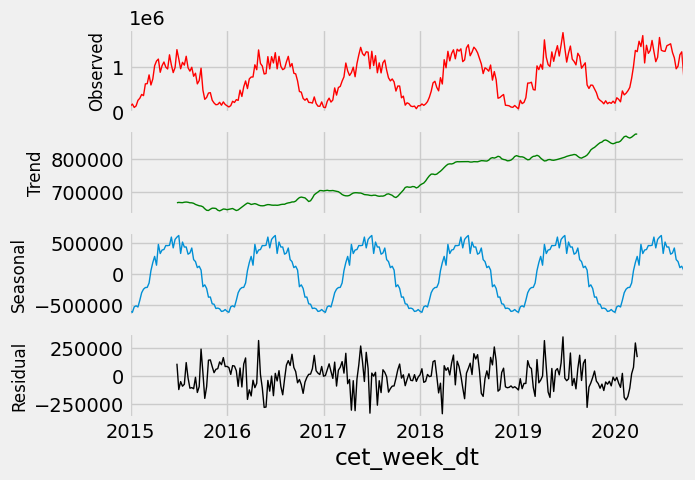

In [175]:
plot_seasonal_components(solar_weekly_ts, weekly_period) # ['solar_generation_actual']

From the decomposition above we can conclude:

- There is a **upward trend**. Therefore, this time series is **not stationary**. 
    - Since our data is not stationary, we need to answer *What differencing will make it stationary?* For this we will use our obtain_adf_kpss_results function to find out how many times we need to apply differencing in order to make this time series stationary. This will be our parameter **d** for the ARIMA model.

- From the **seasonal** component we can observe that the model is **additive**, since the seasonal component is similar (not getting multiplied) over the period of time.

- Also, we can observe on the seasonal component **seasonality** in solar energy generation with lower generation in December-January and higher generation in June-July.


Link: https://www.jadsmkbdatalab.nl/forecasting-with-sarimax-models/
        
        

In [183]:
# d

obtain_adf_kpss_results(solar_weekly_ts, 3)

/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


d     adf_stats  p-value  is_adf_stationary  is_kpss_stationary  \
0  0  4.892079e-10      0.1               True                True   
1  1  3.029011e-04      0.1               True                True   
2  2  1.058041e-17      0.1               True                True   

   is_stationary  
0           True  
1           True  
2           True

Results of stationary tests show that applying differencing only once is enough to make our time series is stationary, i.e., **d = 1**.

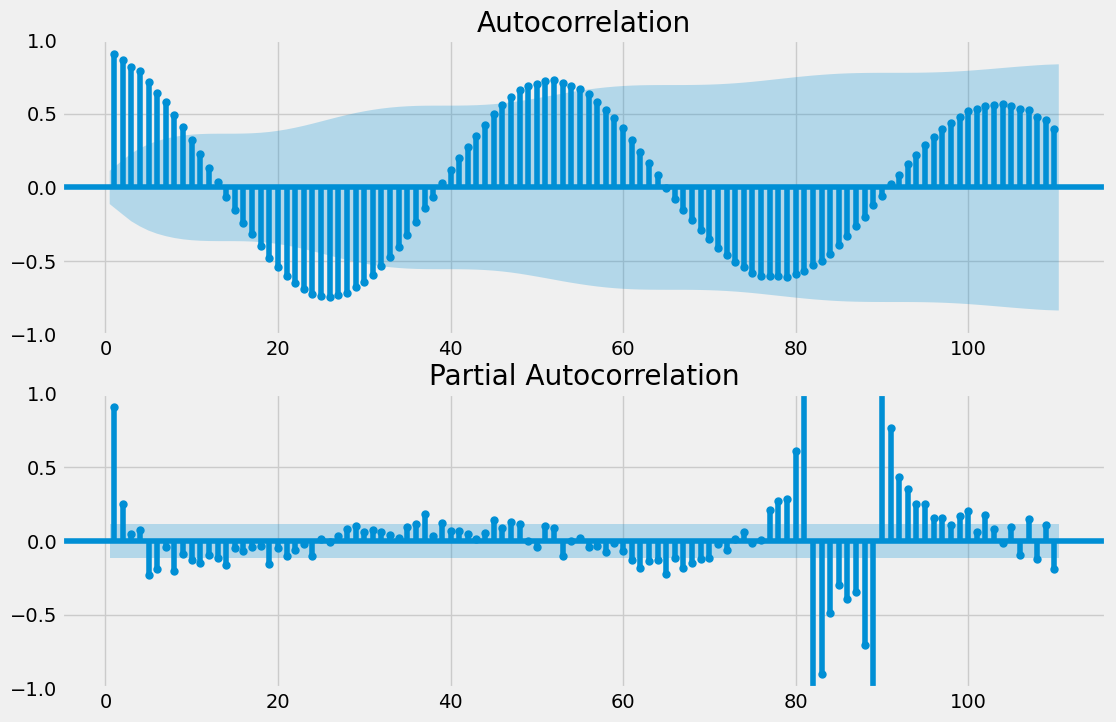

1

In [189]:
plot_acf_pacf(solar_weekly_ts, 110)

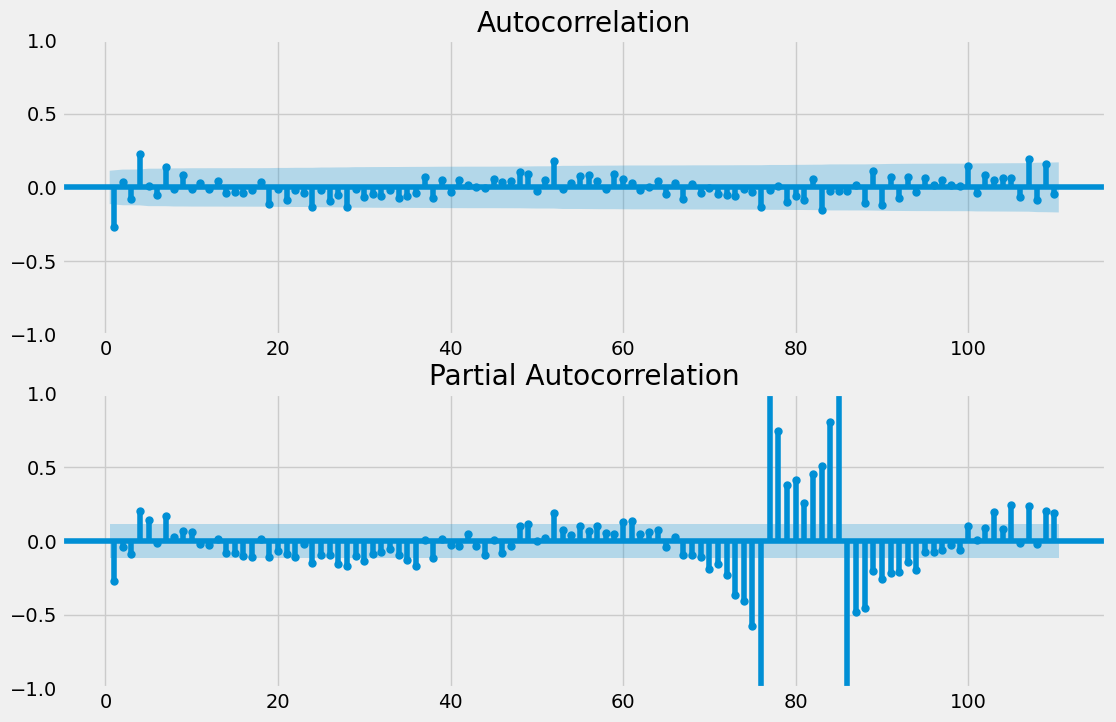

1

In [190]:
plot_acf_pacf(solar_weekly_ts.diff().dropna(), 110)

In [ ]:
# p, q

sort_aic_bic(solar_weekly_ts, 1, 11, 11)

/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-MON w

/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-MON w

/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting

/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Ch

/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters

/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters

/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred f

/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred f

/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-MON w

/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred f

/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Ch

/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred f

/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimizat

/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters

/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters

/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred f

/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters

/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequen

/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequen

/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information w

/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters

/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters

/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters

In [ ]:
solar_weekly_ts_results = arima_diagnostics(solar_weekly_ts, 6,1,6)

In [ ]:
# D



In [ ]:
# P, Q

plot_acf_pacf(solar_weekly_ts.diff().diff(weekly_period).dropna(), 110)

In [ ]:
solar_weekly_ts_seasonal_results = sarima_diagnostics(solar_weekly_ts, 6,1,6,0,1,1,52) # 2,1,2,1,1,1  # 6,1,1,0,1,1,52

In [ ]:
# For time series
run_adf_test(solar_weekly_ts, 0)

# For the first difference of the time series
run_adf_test(solar_weekly_ts, 1)

# For the second difference of the time series
run_adf_test(solar_weekly_ts, 2)

<!--  -->

<a id="ts1"></a>

# 3. Time Series Analysis for Solar Generation in Germany

My goal is to predict **Solar Energy Generation** for 2020 (the period from Jan 1, 2020 to Oct 1, 2020 is on the plot below).

In [48]:
solar_ts = ger_daily_generation_df_slice[['solar_generation_actual']]

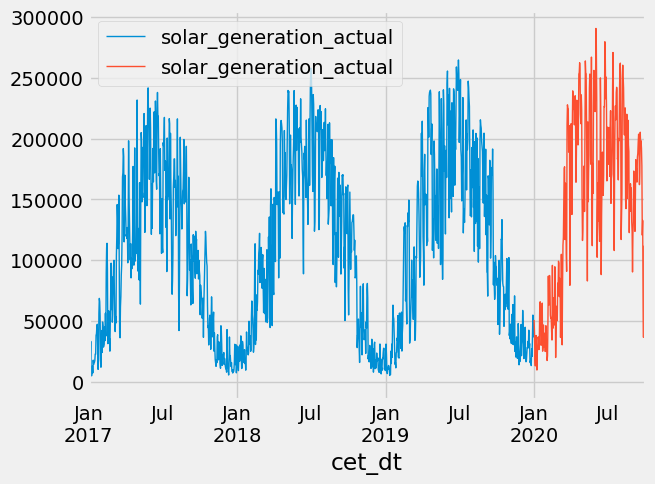

In [49]:
solar_train = solar_ts.loc[:'2019']
solar_test = solar_ts.loc['2020':]

fig, ax = plt.subplots()
solar_train.plot(ax=ax, linewidth=1)
solar_test.plot(ax=ax, linewidth=1)
plt.show()

<a id="identification_ts1"></a>

## 3.1. Identification

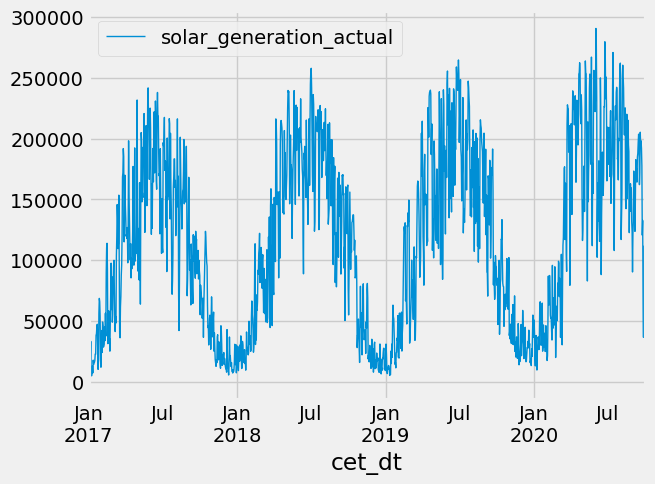

ADF Statistic: -2.548603801922504
p-value: 0.10409175094216644
Critical values: {'1%': -3.4351852261663867, '5%': -2.863675384893896, '10%': -2.5679068804891}


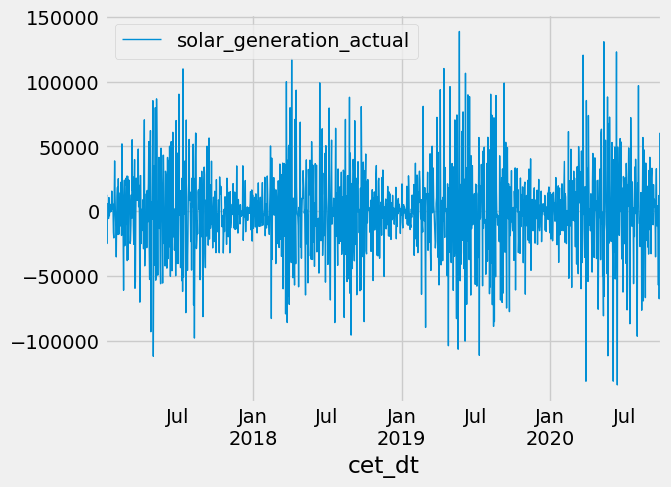

ADF Statistic: -14.095417871185127
p-value: 2.675780239250831e-26
Critical values: {'1%': -3.4351852261663867, '5%': -2.863675384893896, '10%': -2.5679068804891}


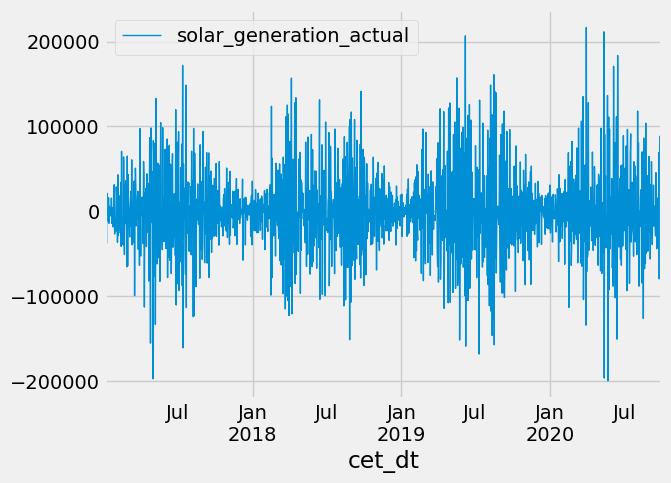

ADF Statistic: -14.305227855369626
p-value: 1.2099951356383072e-26
Critical values: {'1%': -3.43522851297339, '5%': -2.8636944861078013, '10%': -2.5679170525584523}


1

In [50]:
# For time series
run_adf_test(solar_ts, 0)

# For the first difference of the time series
run_adf_test(solar_ts, 1)

# For the second difference of the time series
run_adf_test(solar_ts, 2)

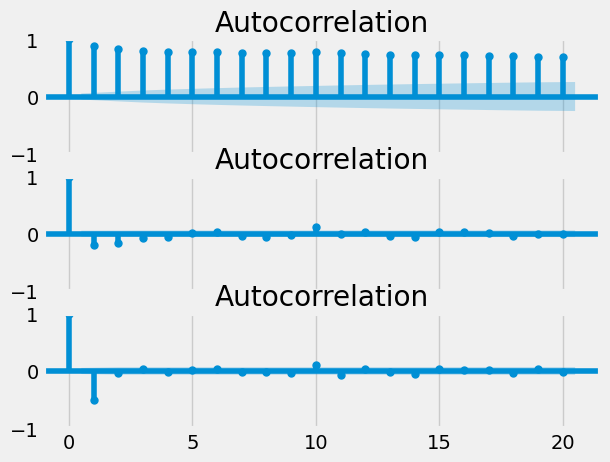

1

In [51]:
plot_acf_functions(solar_ts, 20) # 500

The first difference of the time series looks more stationary than others.

Thus, we should take the first order of differencing **(d = 1)** for ARIMA model.


<a id="estimation_ts1"></a>

## 3.2. Estimation

In [52]:
sort_aic_bic(solar_ts, 1)

/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self.

/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self.

Sorting by AIC:
    p  q           AIC           BIC
15  3  3  32178.626085  32215.178936
6   1  2  32187.716220  32208.603564
10  2  2  32188.558780  32214.667959
7   1  3  32188.944833  32215.054012
3   0  3  32189.996350  32210.883693
9   2  1  32190.299546  32211.186889
11  2  3  32190.908468  32222.239483
14  3  2  32191.186584  32222.517599
13  3  1  32192.062319  32218.171498
5   1  1  32195.110144  32210.775651
2   0  2  32208.170223  32223.835730
12  3  0  32289.778247  32310.665590
8   2  0  32324.313212  32339.978720
1   0  1  32336.571439  32347.015111
4   1  0  32386.081966  32396.525638
0   0  0  32436.306791  32441.528627

Sorting by BIC:
    p  q           AIC           BIC
6   1  2  32187.716220  32208.603564
5   1  1  32195.110144  32210.775651
3   0  3  32189.996350  32210.883693
9   2  1  32190.299546  32211.186889
10  2  2  32188.558780  32214.667959
7   1  3  32188.944833  32215.054012
15  3  3  32178.626085  32215.178936
13  3  1  32192.062319  32218.171498
11  2

/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


1

/opt/homebrew/lib/python3.11/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


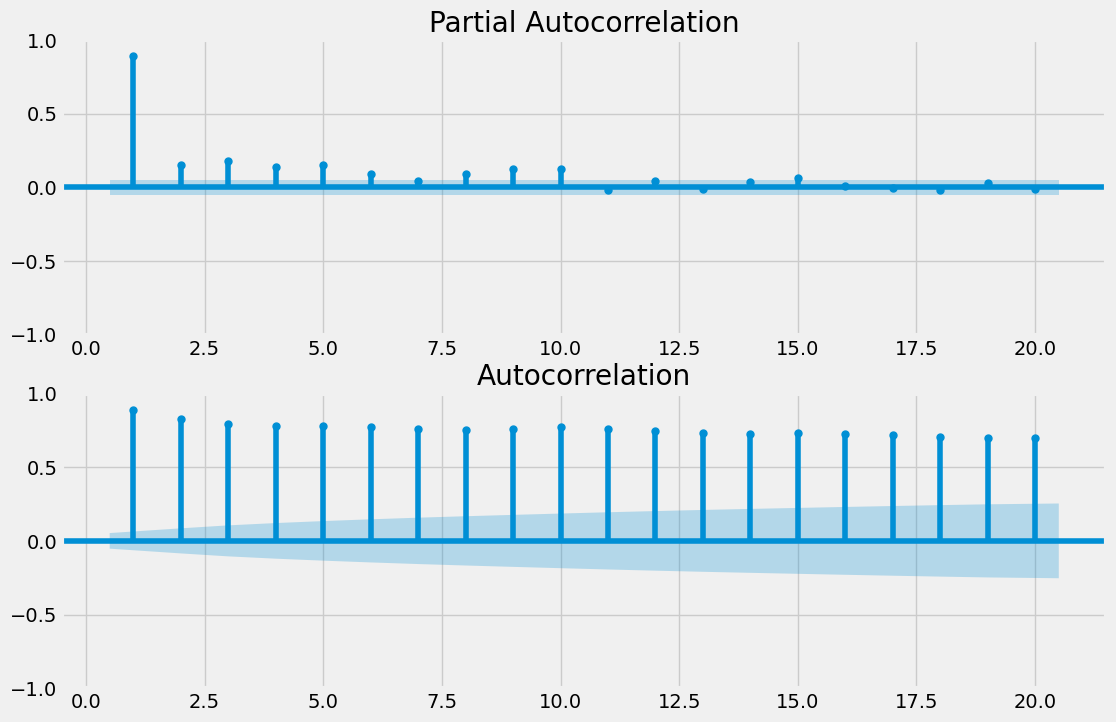

1

In [79]:
plot_acf_pacf(solar_ts, 20)

Thus, we can try to use **p = 3, q = 3** for ARIMA model.

<!-- Thus, we can take **p = 1, q = 2** for ARIMA model. -->

<a id="diagnostics_ts1"></a>

## 3.3. Model diagnostics

/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA paramete

Mean absolute error from residuals: 22635.848669398874

                                  SARIMAX Results                                  
Dep. Variable:     solar_generation_actual   No. Observations:                 1370
Model:                      ARIMA(3, 1, 3)   Log Likelihood              -16082.313
Date:                     Sat, 15 Apr 2023   AIC                          32178.626
Time:                             01:37:11   BIC                          32215.179
Sample:                         01-01-2017   HQIC                         32192.306
                              - 10-01-2020                                         
Covariance Type:                       opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5294      0.029     18.015      0.000       0.472       0.587
ar.L2          0.9597      0.017   

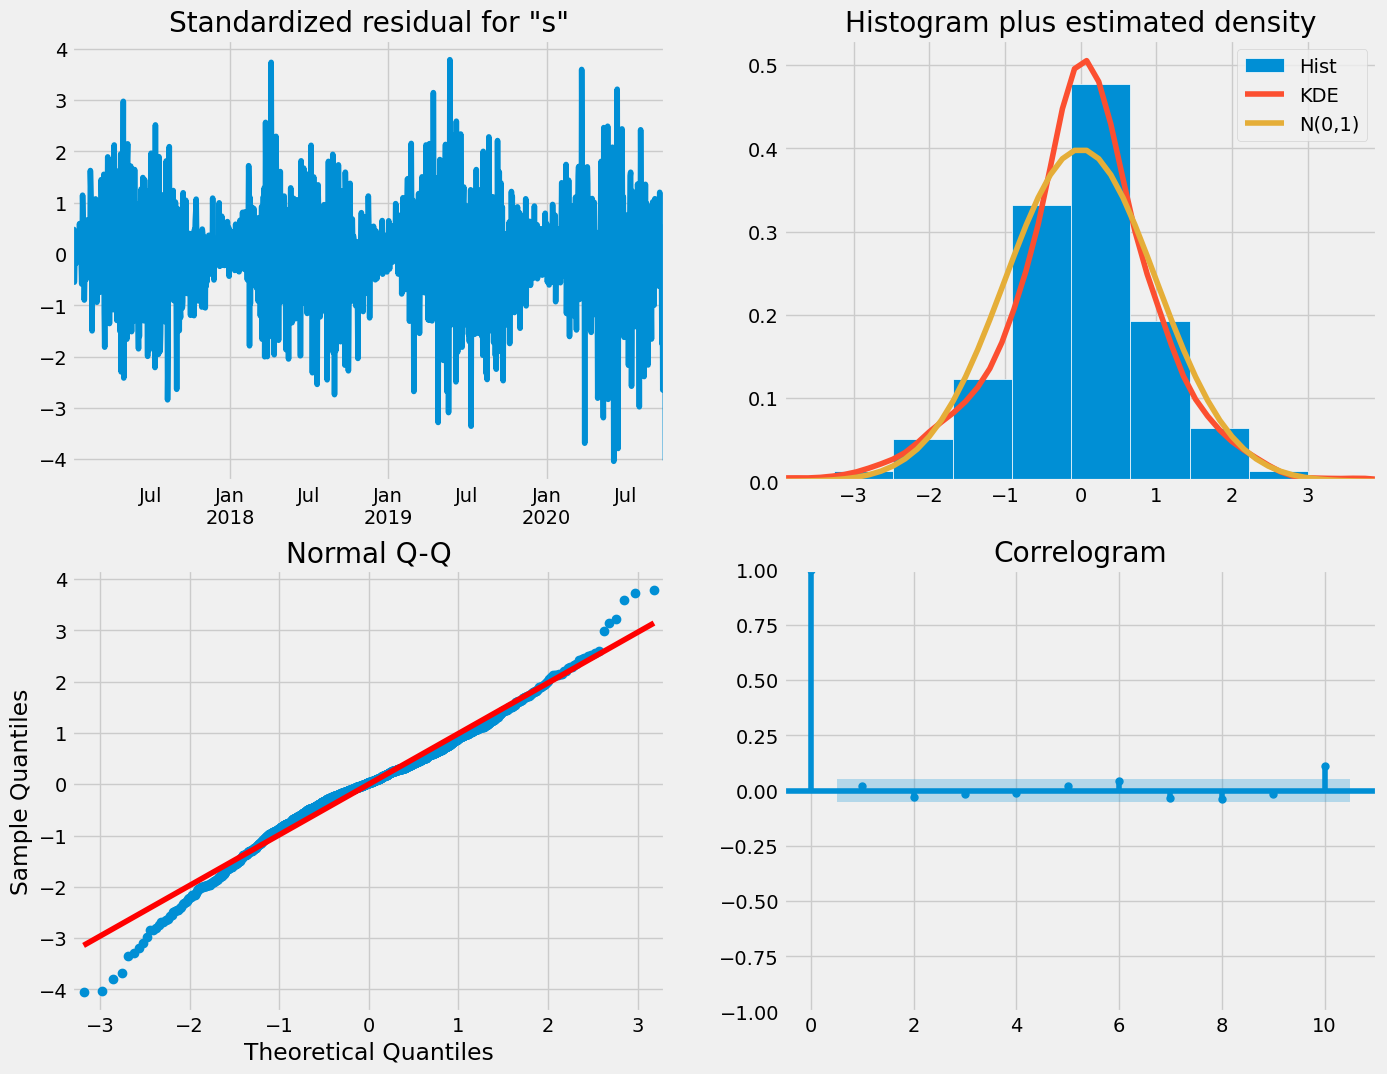

In [54]:
solar_ts_results = arima_diagnostics(solar_ts, 3,1,3)

In [55]:
filled_2020_length = (datetime(2020, 10, 1, 0, 0, 0, 0) - datetime(2020, 1, 1, 0, 0, 0, 0)).days
filled_2020_length

274

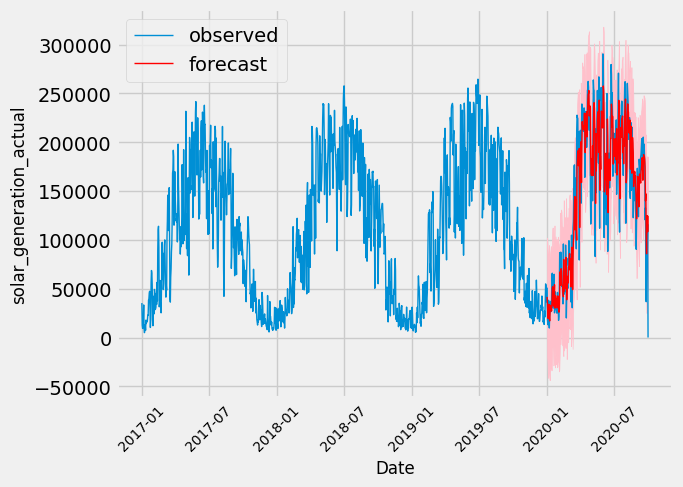

In [56]:
# for non-dynamic

mean_predict, lower_limits, upper_limits = arima_limits(
    solar_ts_results, 'solar_generation_actual', filled_2020_length, False
)
arima_plot(solar_ts, mean_predict, lower_limits, upper_limits)


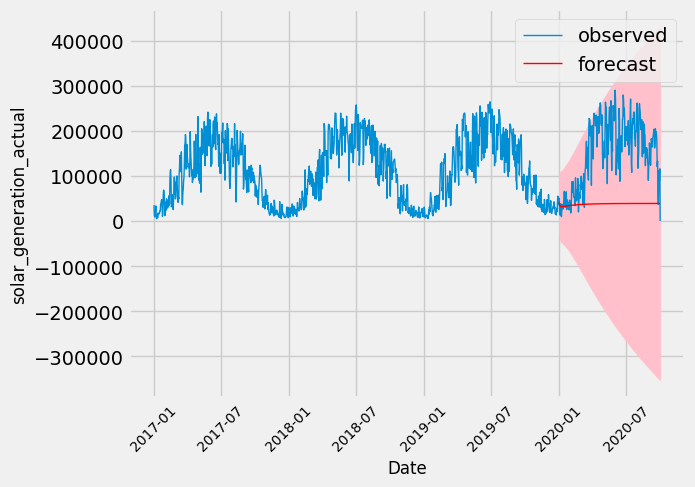

In [57]:
# for dynamic

mean_predict, lower_limits, upper_limits = arima_limits(
    solar_ts_results, 'solar_generation_actual', filled_2020_length, True
)
arima_plot(solar_ts, mean_predict, lower_limits, upper_limits)


<a id="forecasting_ts1"></a>

## 3.4. Forecasting

In [58]:
rest_2020_length = (datetime(2020, 12, 31, 0, 0, 0, 0) - datetime(2020, 10, 1, 0, 0, 0, 0)).days
rest_2020_length

91

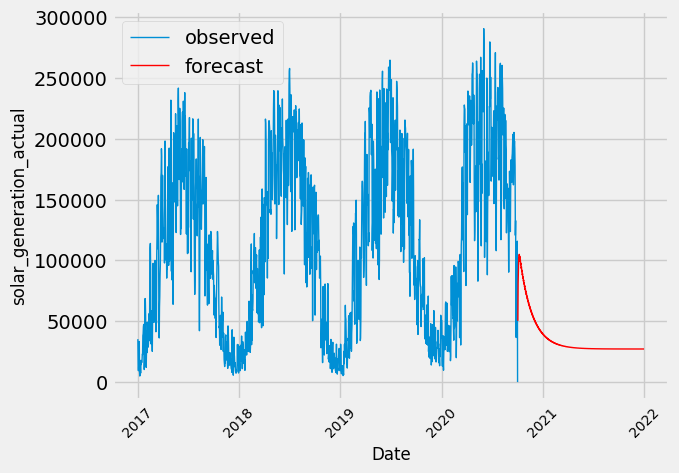

1

In [59]:
solar_ts_forecast = arima_forecast(solar_ts_results, rest_2020_length+365)
arima_plot_future(solar_ts, solar_ts_forecast)

<a id="ts2"></a>

# 4. Time Series Analysis for rolling mean of Solar Generation in Germany (30 days)

In [60]:
solar_rolling_ts = solar_ts[['solar_generation_actual']].rolling(window=30).mean().dropna() # 52

# 7 - bad (flat)
# 14 - bad (tangent flat for d=2)
# 30 - good (for d=0)

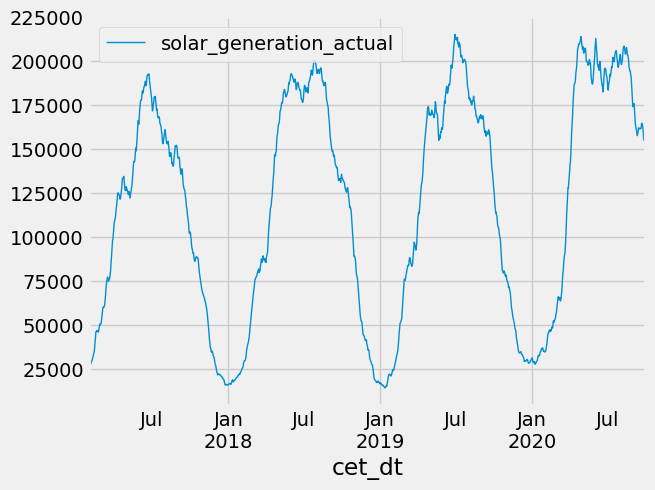

ADF Statistic: -3.7128685209857237
p-value: 0.0039357451048741545
Critical values: {'1%': -3.435325012475485, '5%': -2.8637370675527087, '10%': -2.567939728836562}


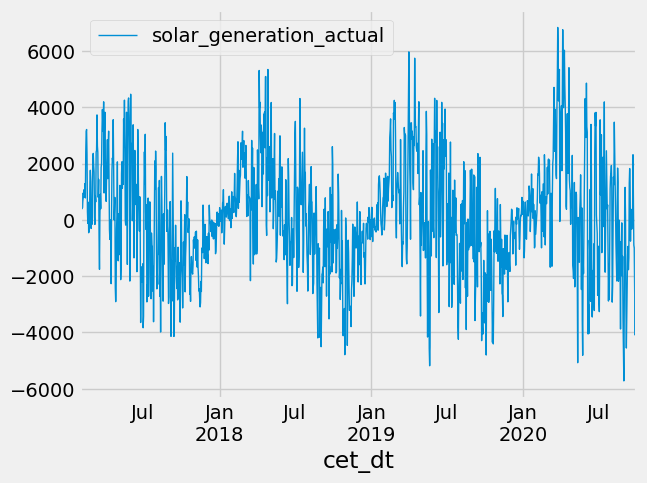

ADF Statistic: -3.6725607351478518
p-value: 0.004516090850380314
Critical values: {'1%': -3.435325012475485, '5%': -2.8637370675527087, '10%': -2.567939728836562}


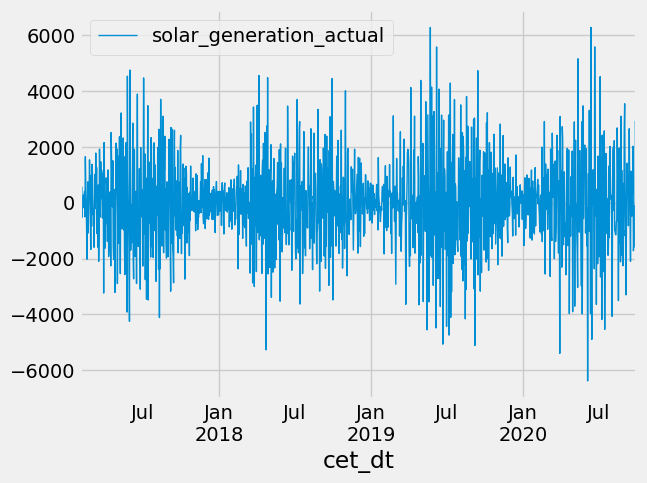

ADF Statistic: -11.8099460501913
p-value: 8.909772338176955e-22
Critical values: {'1%': -3.435325012475485, '5%': -2.8637370675527087, '10%': -2.567939728836562}


1

In [61]:
# For the time series
run_adf_test(solar_rolling_ts, 0)

# For the first difference of the time series
run_adf_test(solar_rolling_ts, 1)

# For the second difference of the time series
run_adf_test(solar_rolling_ts, 2)


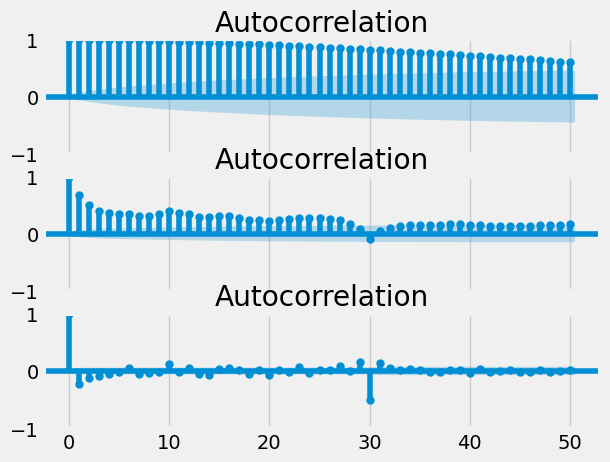

1

In [62]:
plot_acf_functions(solar_rolling_ts, 50) # 500

In [63]:
sort_aic_bic(solar_rolling_ts, 0)

/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self.

/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Usin

Sorting by AIC:
    p  q           AIC           BIC
13  3  1  23289.412774  23320.619799
11  2  3  23302.829754  23339.237950
15  3  3  23321.808827  23363.418194
10  2  2  23334.756663  23365.963688
14  3  2  23349.128278  23385.536475
9   2  1  23369.696500  23395.702355
12  3  0  23372.216379  23398.222233
8   2  0  23378.497836  23399.302519
7   1  3  23443.951276  23475.158301
6   1  2  23504.769524  23530.775379
5   1  1  23662.784017  23683.588700
4   1  0  24186.600449  24202.203962
2   0  2  29993.640734  30014.445417
3   0  3  30072.989574  30098.995428
1   0  1  31676.333845  31691.937358
0   0  0  41808.636049  41819.038391

Sorting by BIC:
    p  q           AIC           BIC
13  3  1  23289.412774  23320.619799
11  2  3  23302.829754  23339.237950
15  3  3  23321.808827  23363.418194
10  2  2  23334.756663  23365.963688
14  3  2  23349.128278  23385.536475
9   2  1  23369.696500  23395.702355
12  3  0  23372.216379  23398.222233
8   2  0  23378.497836  23399.302519
7   1

/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


1

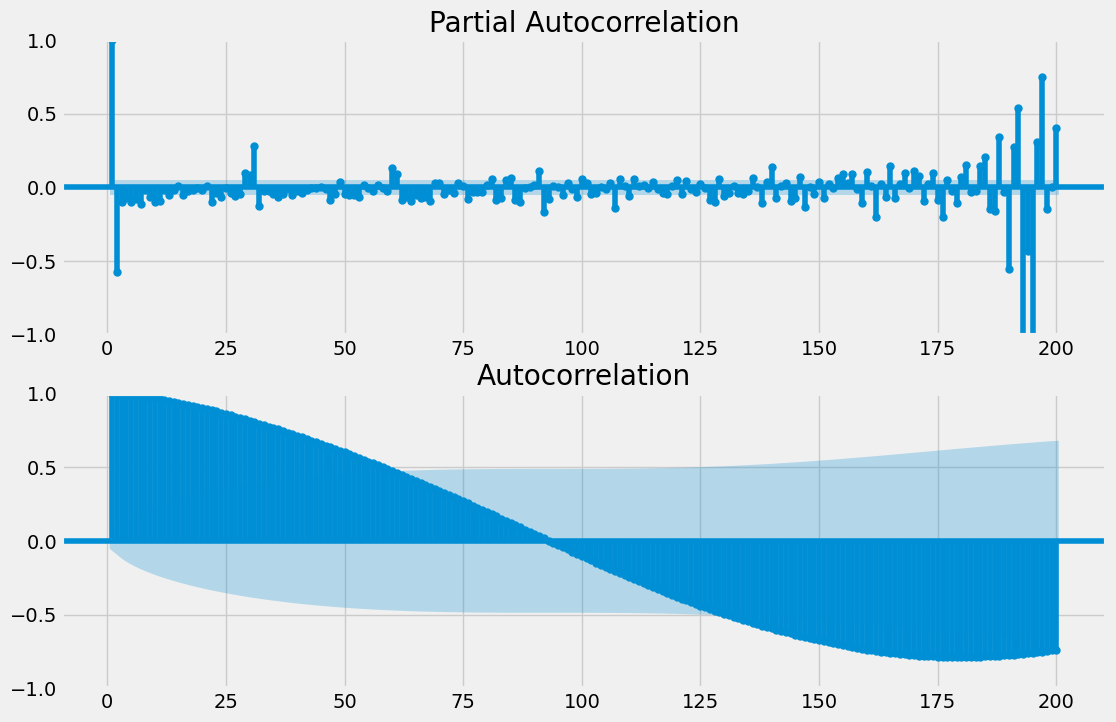

1

In [81]:
plot_acf_pacf(solar_rolling_ts, 200) # 500

/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Mean absolute error from residuals: 1143.0186752317722

                                  SARIMAX Results                                  
Dep. Variable:     solar_generation_actual   No. Observations:                 1341
Model:                      ARIMA(3, 0, 1)   Log Likelihood              -11638.706
Date:                     Sat, 15 Apr 2023   AIC                          23289.413
Time:                             01:38:47   BIC                          23320.620
Sample:                         01-30-2017   HQIC                         23301.104
                              - 10-01-2020                                         
Covariance Type:                       opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        1.18e+05   6.79e-08   1.74e+12      0.000    1.18e+05    1.18e+05
ar.L1          2.5360      0.024   

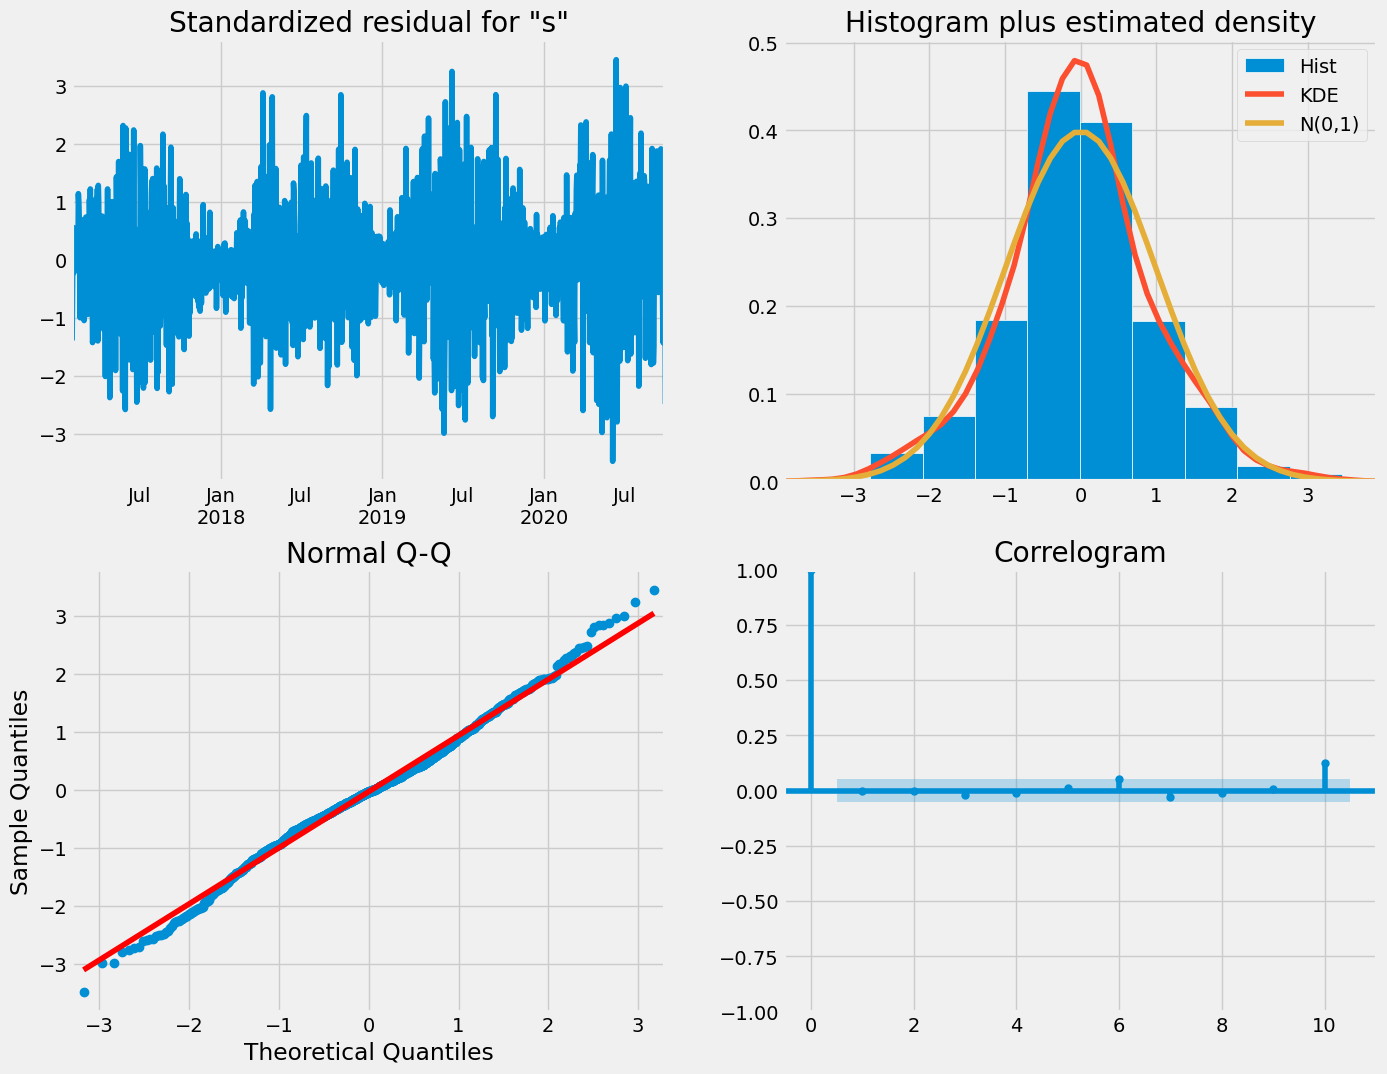

In [65]:
solar_rolling_ts_results = arima_diagnostics(solar_rolling_ts, 3,0,1)

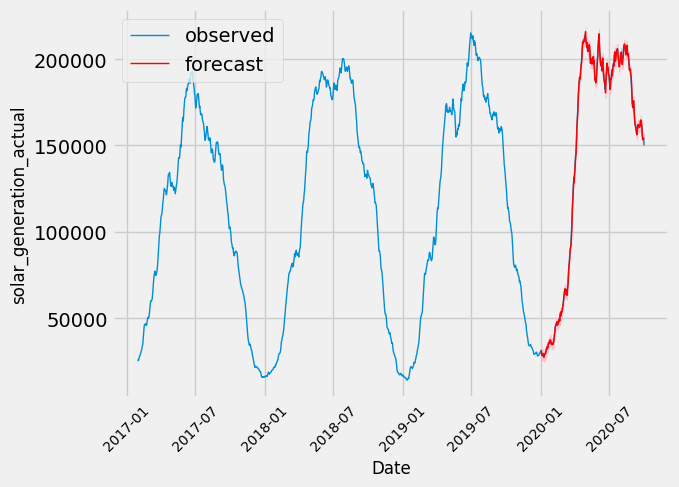

In [66]:
mean_forecast, lower_limits, upper_limits = arima_limits(
    solar_rolling_ts_results, 'solar_generation_actual', 274, False
)
arima_plot(solar_rolling_ts, mean_forecast, lower_limits, upper_limits)


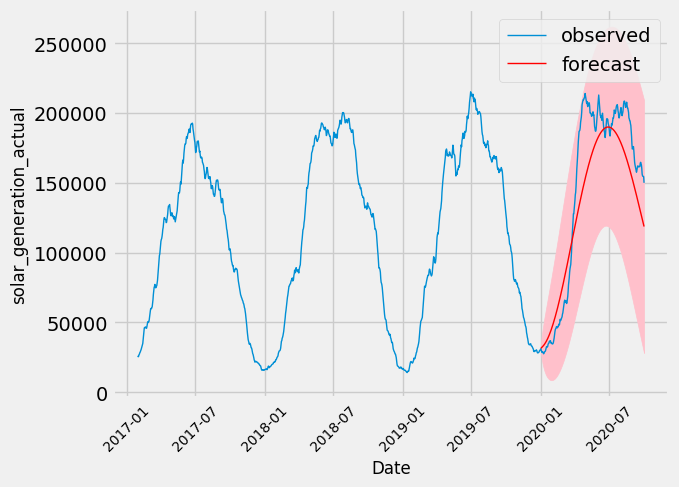

In [67]:
mean_forecast, lower_limits, upper_limits = arima_limits(
    solar_rolling_ts_results, 'solar_generation_actual', 274, True
)
arima_plot(solar_rolling_ts, mean_forecast, lower_limits, upper_limits)


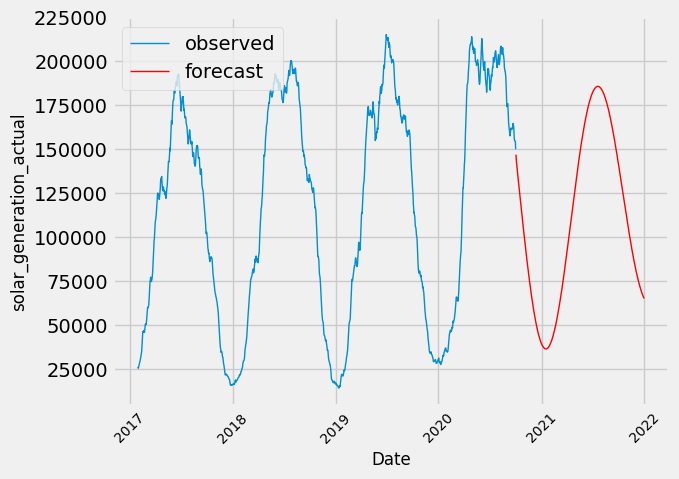

1

In [68]:
rolling_forecast = solar_rolling_ts_results.get_forecast(steps=91+365).predicted_mean

arima_plot_future(solar_rolling_ts, rolling_forecast)

<a id="ts3"></a>

# 5. WEEKLY TS

In [102]:
solar_weekly_ts = ger_weekly_generation_df[['solar_generation_actual']]

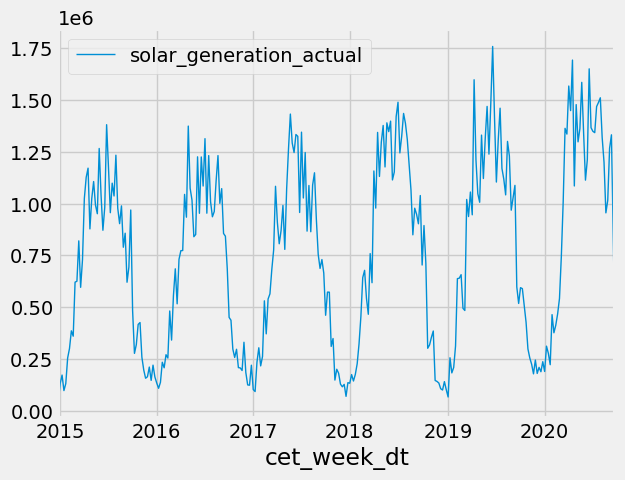

ADF Statistic: -7.072644689206454
p-value: 4.89207899498438e-10
Critical values: {'1%': -3.453342167806272, '5%': -2.871663828287282, '10%': -2.572164381381345}


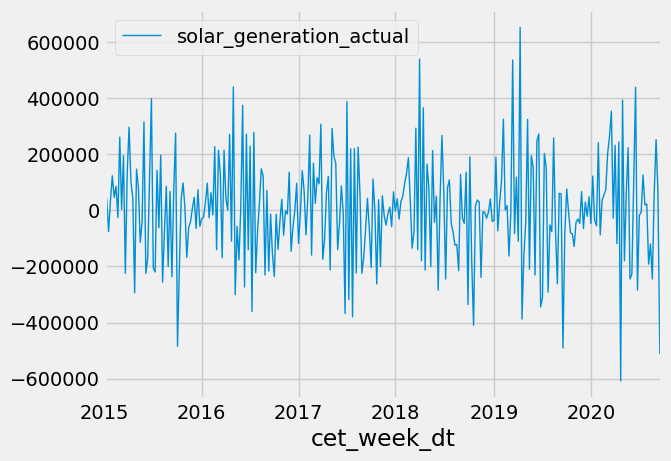

ADF Statistic: -4.395030962439947
p-value: 0.0003029011399663959
Critical values: {'1%': -3.452867117291862, '5%': -2.8714554160827745, '10%': -2.5720532321867466}


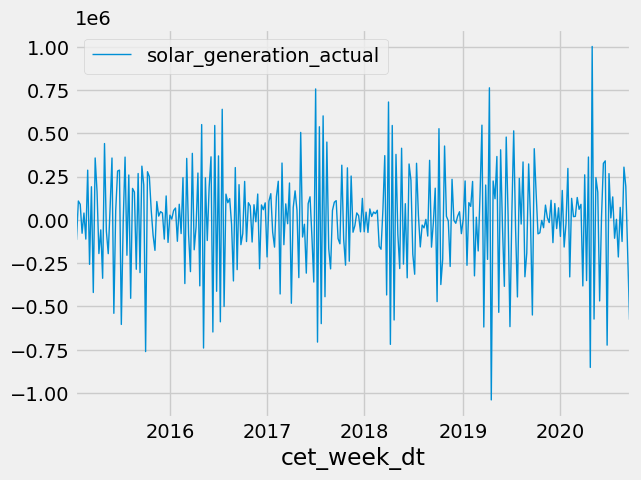

ADF Statistic: -10.101253617621355
p-value: 1.0580408115381865e-17
Critical values: {'1%': -3.453102162983312, '5%': -2.871558538275452, '10%': -2.5721082282996433}


1

In [103]:
# For time series
run_adf_test(solar_weekly_ts, 0)

# For the first difference of the time series
run_adf_test(solar_weekly_ts, 1)

# For the second difference of the time series
run_adf_test(solar_weekly_ts, 2)

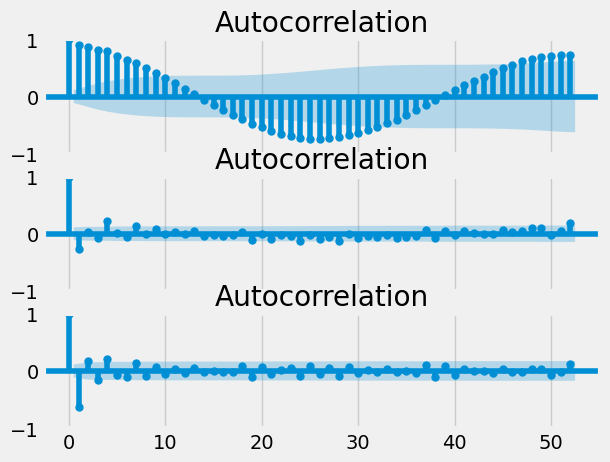

1

In [105]:
plot_acf_functions(solar_weekly_ts, 52) # 500

In [106]:
sort_aic_bic(solar_weekly_ts, 1)

/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-MON w

/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-MON w

Sorting by AIC:
    p  q          AIC          BIC
10  2  2  8110.117183  8128.636096
7   1  3  8111.783935  8130.302847
6   1  2  8114.014061  8128.829191
14  3  2  8117.112718  8139.335412
11  2  3  8117.920512  8140.143207
15  3  3  8119.139816  8145.066294
1   0  1  8123.620155  8131.027720
13  3  1  8124.045492  8142.564405
4   1  0  8124.227612  8131.635177
12  3  0  8124.876231  8139.691361
2   0  2  8125.237486  8136.348834
5   1  1  8125.283652  8136.394999
8   2  0  8125.524701  8136.636048
3   0  3  8125.697032  8140.512162
9   2  1  8127.257030  8142.072160
0   0  0  8145.283904  8148.987686

Sorting by BIC:
    p  q          AIC          BIC
10  2  2  8110.117183  8128.636096
6   1  2  8114.014061  8128.829191
7   1  3  8111.783935  8130.302847
1   0  1  8123.620155  8131.027720
4   1  0  8124.227612  8131.635177
2   0  2  8125.237486  8136.348834
5   1  1  8125.283652  8136.394999
8   2  0  8125.524701  8136.636048
14  3  2  8117.112718  8139.335412
12  3  0  8124.876231 

1

/opt/homebrew/lib/python3.11/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


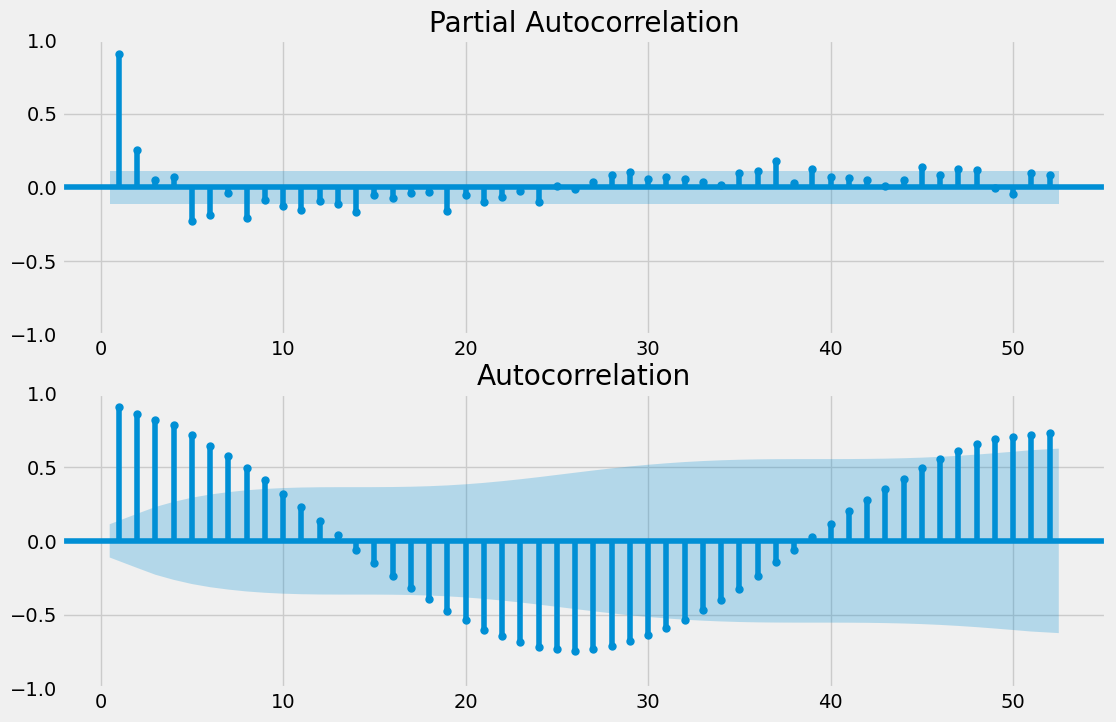

1

In [107]:
plot_acf_pacf(solar_weekly_ts, 52)

/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)


Mean absolute error from residuals: 133213.9962950156

                                  SARIMAX Results                                  
Dep. Variable:     solar_generation_actual   No. Observations:                  301
Model:                      ARIMA(2, 1, 2)   Log Likelihood               -4050.059
Date:                     Sat, 15 Apr 2023   AIC                           8110.117
Time:                             17:00:25   BIC                           8128.636
Sample:                         12-29-2014   HQIC                          8117.528
                              - 09-28-2020                                         
Covariance Type:                       opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.2204      0.115     10.629      0.000       0.995       1.445
ar.L2         -0.3093      0.112    

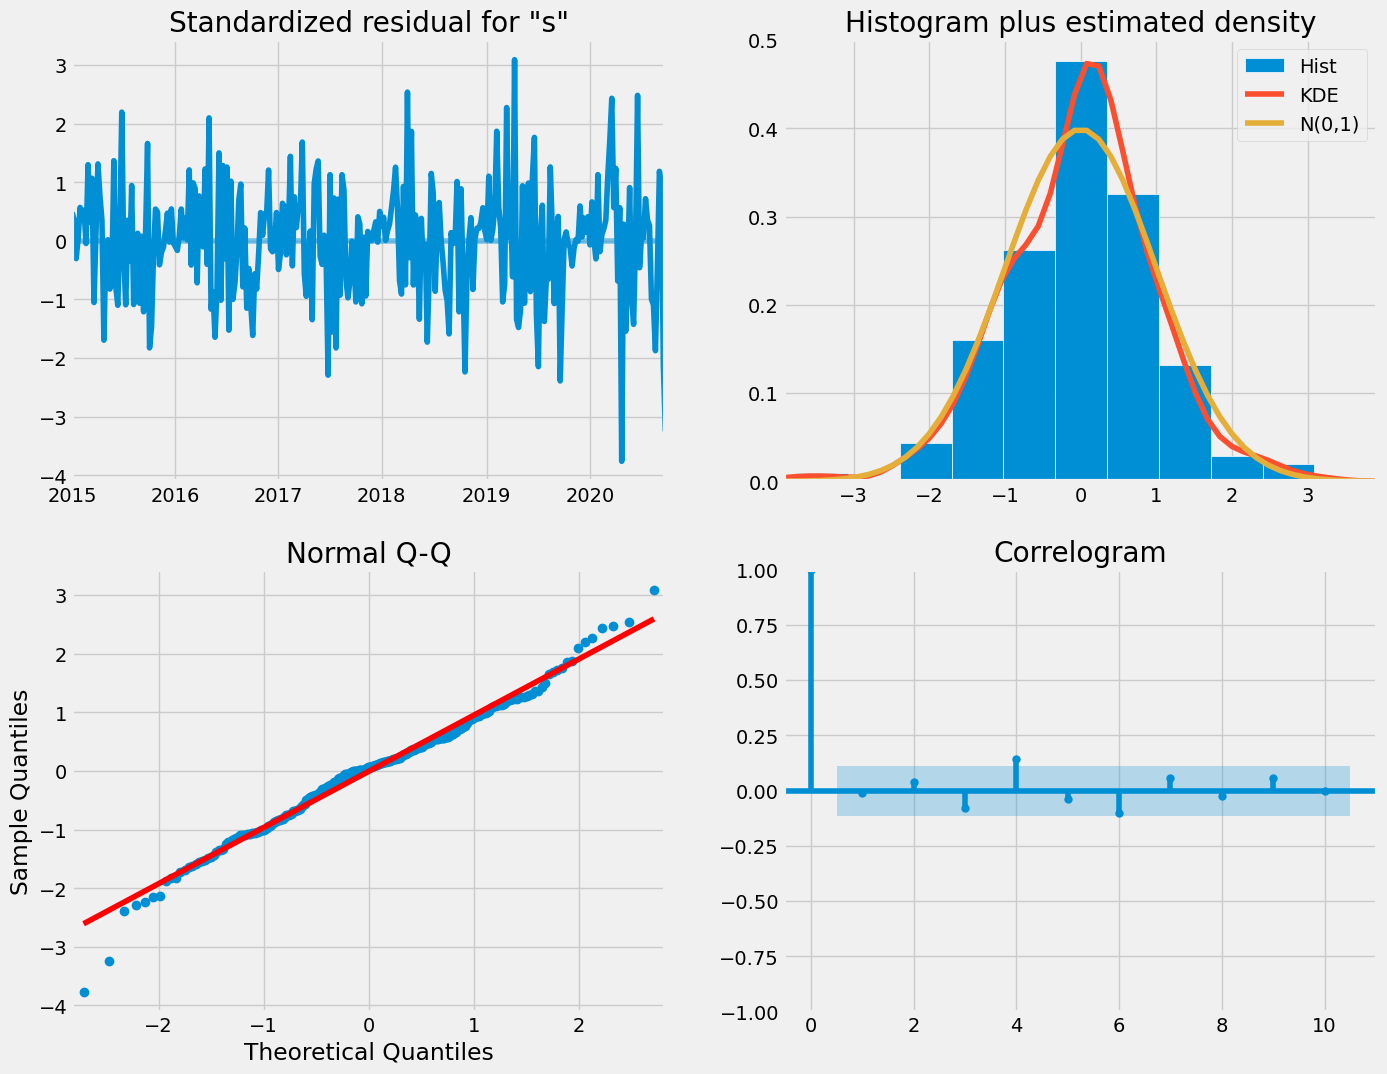

In [109]:
solar_weekly_ts_results = arima_diagnostics(solar_weekly_ts, 2,1,2)

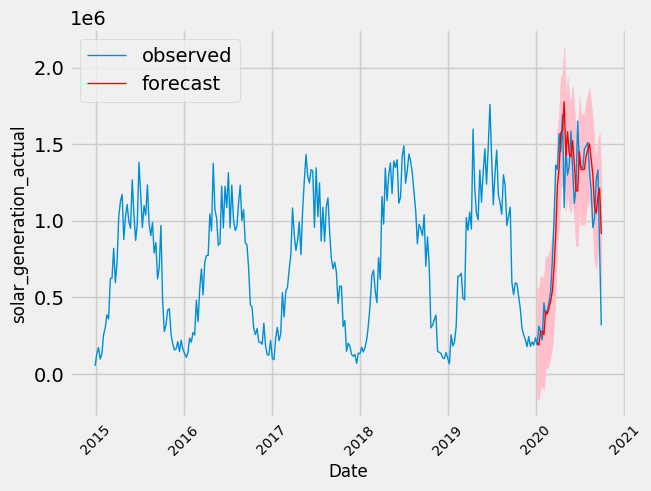

In [112]:
# for non-dynamic

mean_predict, lower_limits, upper_limits = arima_limits(
    solar_weekly_ts_results, 'solar_generation_actual', filled_2020_length//7, False
)
arima_plot(solar_weekly_ts, mean_predict, lower_limits, upper_limits)


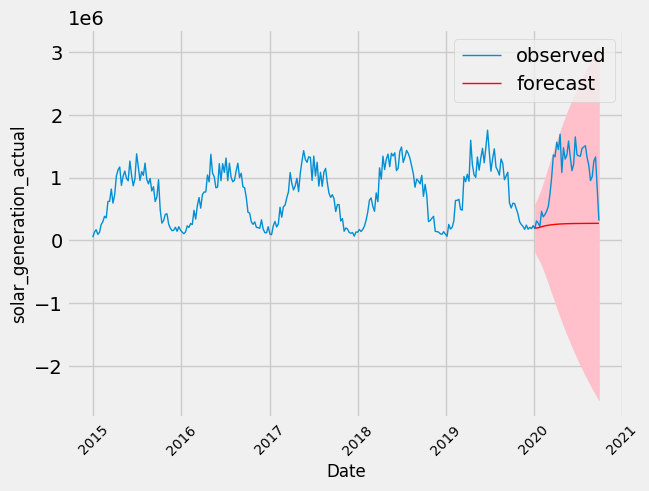

In [113]:
# for dynamic

mean_predict, lower_limits, upper_limits = arima_limits(
    solar_weekly_ts_results, 'solar_generation_actual', filled_2020_length//7, True
)
arima_plot(solar_weekly_ts, mean_predict, lower_limits, upper_limits)


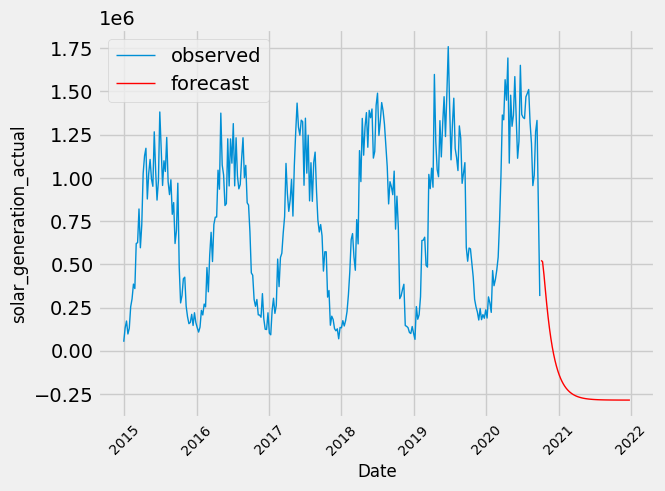

1

In [114]:
solar_weekly_ts_forecast = arima_forecast(solar_weekly_ts_results, (rest_2020_length+365)//7)
arima_plot_future(solar_weekly_ts, solar_weekly_ts_forecast)

Text(0, 0.5, 'Residual')

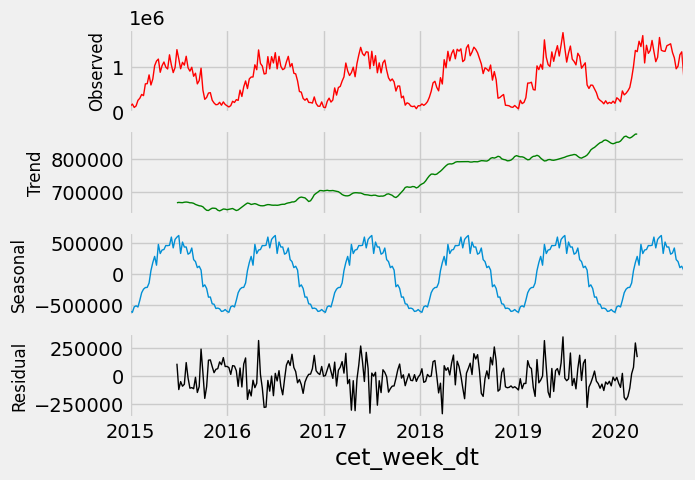

In [116]:
decomp_weekly = seasonal_decompose(solar_weekly_ts['solar_generation_actual'], period=52)

fig, axes = plt.subplots(4, 1, sharex=True)

decomp_weekly.observed.plot(ax=axes[0], legend=False, color='r', linewidth=1)
axes[0].set_ylabel('Observed', fontsize=12)

decomp_weekly.trend.plot(ax=axes[1], legend=False, color='g', linewidth=1)
axes[1].set_ylabel('Trend', fontsize=12)

decomp_weekly.seasonal.plot(ax=axes[2], legend=False, linewidth=1)
axes[2].set_ylabel('Seasonal', fontsize=12)

decomp_weekly.resid.plot(ax=axes[3], legend=False, color='k', linewidth=1)
axes[3].set_ylabel('Residual', fontsize=12)

In [162]:
seasonal_weekly_model = ARIMA(solar_weekly_ts, order=(6,1,1), seasonal_order=(0,1,1,52)) # # 2,1,2,1,1,1
seasonal_weekly_results = seasonal_weekly_model.fit() # method='innovations_mle', low_memory=True, cov_type='none'

print(seasonal_weekly_results.summary())

/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)


                                    SARIMAX Results                                     
Dep. Variable:          solar_generation_actual   No. Observations:                  301
Model:             ARIMA(6, 1, 1)x(0, 1, 1, 52)   Log Likelihood               -3340.028
Date:                          Sat, 15 Apr 2023   AIC                           6698.056
Time:                                  20:35:21   BIC                           6729.677
Sample:                              12-29-2014   HQIC                          6710.786
                                   - 09-28-2020                                         
Covariance Type:                            opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0343      0.327     -0.105      0.916      -0.676       0.608
ar.L2         -0.0305      0.191     -0.159      0.

<!-- Prob(Q) < 0.05, so we should reject the null that the residuals are uncorrelated.

Prob(JB) < 0.05, so we should reject the null that the residuals are normally distributed. -->

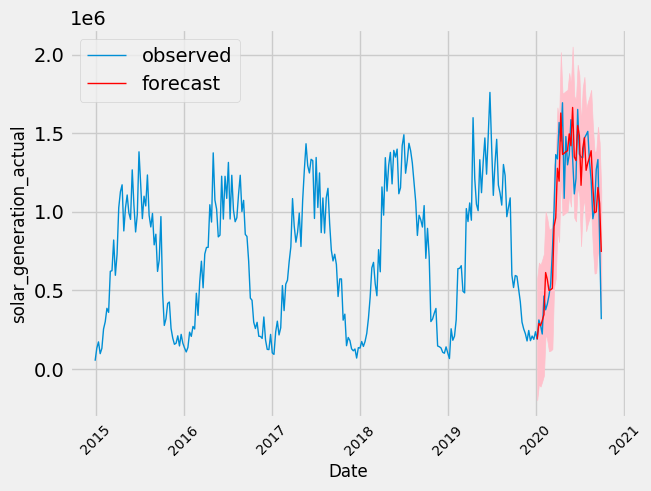

In [163]:
mean_forecast, lower_limits, upper_limits = arima_limits(
    seasonal_weekly_results, 'solar_generation_actual', 274//7, False
)
arima_plot(solar_weekly_ts, mean_forecast, lower_limits, upper_limits)


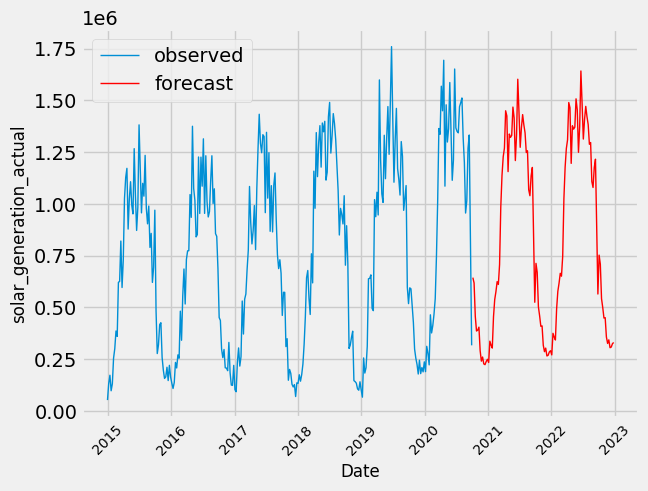

1

In [164]:
seasonal_weekly_forecast = seasonal_weekly_results.get_forecast(steps=(91+365+365)//7).predicted_mean

arima_plot_future(solar_weekly_ts, seasonal_weekly_forecast)

/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)


Mean absolute error from residuals: 134830.1778809141

                                    SARIMAX Results                                     
Dep. Variable:          solar_generation_actual   No. Observations:                  301
Model:             ARIMA(6, 1, 1)x(0, 1, 1, 52)   Log Likelihood               -3340.028
Date:                          Sat, 15 Apr 2023   AIC                           6698.056
Time:                                  20:34:24   BIC                           6729.677
Sample:                              12-29-2014   HQIC                          6710.786
                                   - 09-28-2020                                         
Covariance Type:                            opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0343      0.327     -0.105      0.916      -0.676       0.

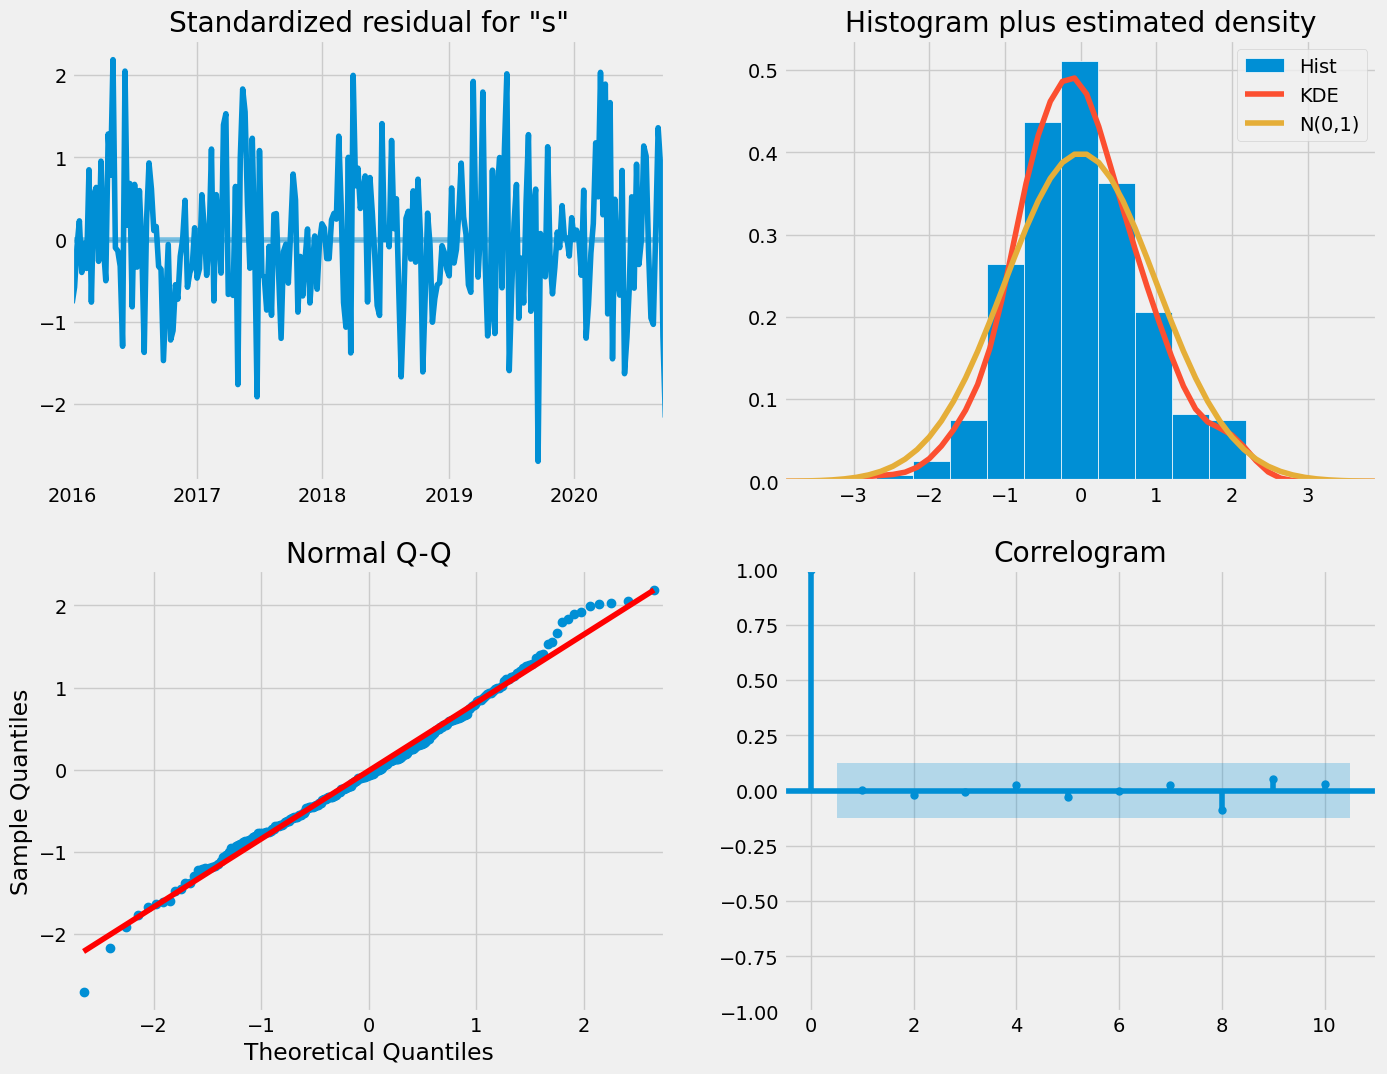

In [161]:
# should I do this?

solar_weekly_ts_seasonal_results = sarima_diagnostics(solar_weekly_ts, 6,1,1,0,1,1,52) # 2,1,2,1,1,1

In [165]:
week_period = 52

# Take the first and seasonal differences and drop NaNs
solar_weekly_ts_diff = solar_weekly_ts.diff().diff(week_period).dropna()

/opt/homebrew/lib/python3.11/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


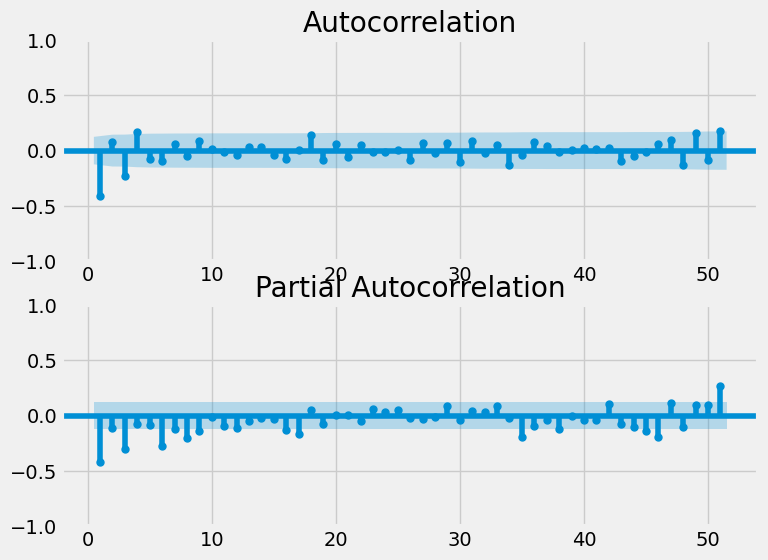

In [166]:
# Create the figure 
fig, (ax1, ax2) = plt.subplots(2,1,figsize=(8,6))

plot_acf(solar_weekly_ts_diff, lags=week_period-1, zero=False, ax=ax1)
plot_pacf(solar_weekly_ts_diff, lags=week_period-1, zero=False, ax=ax2)

plt.show()

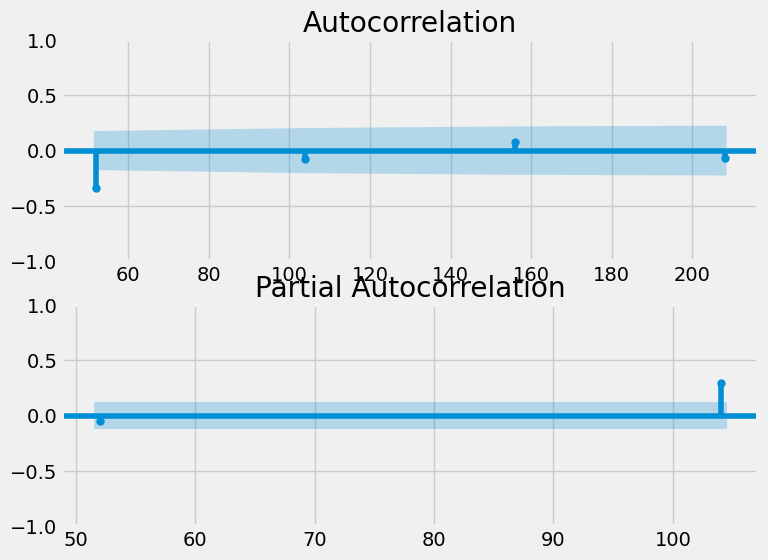

In [170]:
# Make list of lags
lags = [k * week_period for k in range(1, 6)]

# Create the figure 
fig, (ax1, ax2) = plt.subplots(2,1,figsize=(8,6))

# Plot the ACF on ax1
plot_acf(solar_weekly_ts_diff, lags=lags[:4], ax=ax1)

# Plot the PACF on ax2
plot_pacf(solar_weekly_ts_diff, lags=lags[:2], ax=ax2)

plt.show()

In [ ]:
# FOR CHECKING: 

In [157]:
import pmdarima as pm

In [158]:
model1 = pm.auto_arima(solar_weekly_ts, #time series
                      seasonal=True, # is the time series seasonal
                      m=52, # the seasonal period - 52 weeks
                      d=1, # non-seasonal difference order
                      D=1, # seasonal difference order
                 	  max_p=6, # max value of p to test 
                      max_q=6, # max value of q to test
                      max_P=6, # max value of P to test 
                      max_Q=6, # max value of Q to test 
                      information_criterion='aic', # used to select best mode
                      trace=True, # prints the information_criterion for each model it fits
                      error_action='ignore', # ignore orders that don't work
                      stepwise=True, # apply an intelligent order search
                      suppress_warnings=True) 

# Print model summary
print(model1.summary())

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,1,1)[52]             : AIC=6704.754, Time=13.05 sec
 ARIMA(0,1,0)(0,1,0)[52]             : AIC=6848.886, Time=0.16 sec
 ARIMA(1,1,0)(1,1,0)[52]             : AIC=6741.952, Time=2.29 sec
 ARIMA(0,1,1)(0,1,1)[52]             : AIC=inf, Time=4.20 sec
 ARIMA(2,1,2)(0,1,1)[52]             : AIC=6703.896, Time=11.13 sec
 ARIMA(2,1,2)(0,1,0)[52]             : AIC=6758.432, Time=1.52 sec
 ARIMA(2,1,2)(0,1,2)[52]             : AIC=6704.315, Time=26.93 sec
 ARIMA(2,1,2)(1,1,0)[52]             : AIC=6714.372, Time=13.55 sec
 ARIMA(2,1,2)(1,1,2)[52]             : AIC=6705.948, Time=41.16 sec
 ARIMA(1,1,2)(0,1,1)[52]             : AIC=inf, Time=7.83 sec
 ARIMA(2,1,1)(0,1,1)[52]             : AIC=6706.098, Time=8.09 sec
 ARIMA(3,1,2)(0,1,1)[52]             : AIC=6703.652, Time=11.94 sec
 ARIMA(3,1,2)(0,1,0)[52]             : AIC=6756.434, Time=1.63 sec
 ARIMA(3,1,2)(1,1,1)[52]             : AIC=6704.596, Time=17.88 sec
 ARIMA(3,1,2)(0,1,2)[5

In [160]:
seasonal_weekly_forecast_pm = model1.forecast(steps=(91+365+365)//7).predicted_mean

arima_plot_future(solar_weekly_ts, seasonal_weekly_forecast_pm)

AttributeError: 'ARIMA' object has no attribute 'forecast'

In [ ]:
train, test = solar_weekly_ts.iloc[:-TEST_SIZE], solar_weekly_ts.iloc[-TEST_SIZE:]


In [ ]:
prediction, confint = model1.predict(n_periods=TEST_SIZE, return_conf_int=True)

cf = pd.DataFrame(confint)

prediction_series = pd.Series(prediction) # , index=test.index
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
ax.plot(data.Value)
ax.plot(prediction_series)
ax.fill_between(prediction_series.index,
                cf[0],
                cf[1],color='grey',alpha=.3)

<a id="seasonal"></a>

# 5. Seasonal TS

In [69]:
# Perform additive decomposition
decomp = seasonal_decompose(solar_ts['solar_generation_actual'], period=365)
# decomp.plot()
# plt.show()

Text(0, 0.5, 'Residual')

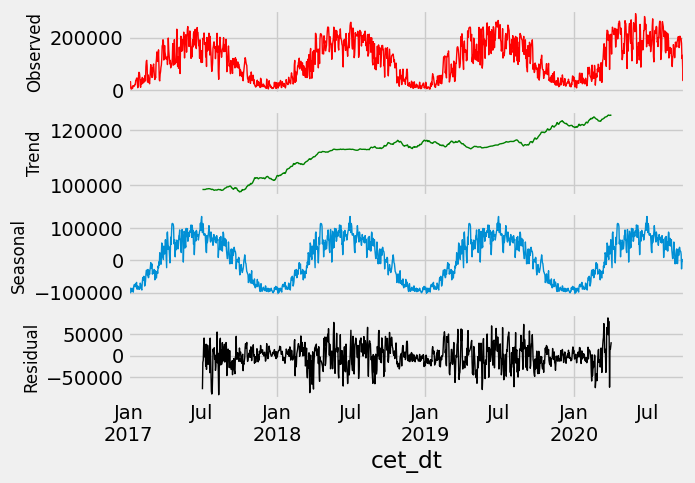

In [70]:
fig, axes = plt.subplots(4, 1, sharex=True)

decomp.observed.plot(ax=axes[0], legend=False, color='r', linewidth=1)
axes[0].set_ylabel('Observed', fontsize=12)

decomp.trend.plot(ax=axes[1], legend=False, color='g', linewidth=1)
axes[1].set_ylabel('Trend', fontsize=12)

decomp.seasonal.plot(ax=axes[2], legend=False, linewidth=1)
axes[2].set_ylabel('Seasonal', fontsize=12)

decomp.resid.plot(ax=axes[3], legend=False, color='k', linewidth=1)
axes[3].set_ylabel('Residual', fontsize=12)

### + SARIMA models (????)

SARIMA = Seasonal ARIMA

SARIMA(p,d,q)(P,D,Q)S

P, D, Q - seasonal p, d, q

S - number of time steps per cycle

In [72]:
# 365 -- too long
    
seasonal_model = SARIMAX(solar_ts, order=(3,1,3), seasonal_order=(0,1,0,365), simple_differencing=True)
seasonal_results = seasonal_model.fit()

print(seasonal_results.summary())

/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.22340D+01    |proj g|=  2.47531D-01

At iterate    5    f=  1.21027D+01    |proj g|=  5.70868D-02

At iterate   10    f=  1.20897D+01    |proj g|=  7.53453D-03

At iterate   15    f=  1.20892D+01    |proj g|=  2.63957D-04

At iterate   20    f=  1.20880D+01    |proj g|=  3.50406D-02

At iterate   25    f=  1.20857D+01    |proj g|=  9.32597D-03

At iterate   30    f=  1.20835D+01    |proj g|=  1.18299D-03

At iterate   35    f=  1.20832D+01    |proj g|=  5.61319D-03

At iterate   40    f=  1.20819D+01    |proj g|=  9.86164D-03

At iterate   45    f=  1.20802D+01    |proj g|=  2.10150D-03

At iterate   50    f=  1.20800D+01    |proj g|=  4.96288D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


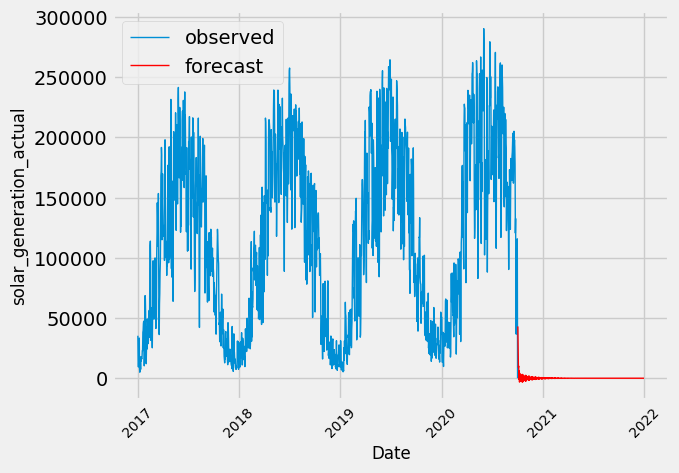

1

In [73]:
seasonal_forecast = seasonal_results.get_forecast(steps=91+365).predicted_mean

arima_plot_future(solar_ts, seasonal_forecast)

In [74]:
seasonal_model2 = ARIMA(solar_ts, order=(3,1,3), seasonal_order=(0,1,0,365))
seasonal_results2 = seasonal_model2.fit(method='innovations_mle', low_memory=True, cov_type='none')

print(seasonal_results2.summary())

/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/arima/model.py:403: UserWarning: Provided `endog` series has been differenced to eliminate integration prior to parameter estimation by method "innovations_mle".
  warnings.warn('Provided `endog` series has been differenced'


                                     SARIMAX Results                                      
Dep. Variable:            solar_generation_actual   No. Observations:                 1370
Model:             ARIMA(3, 1, 3)x(0, 1, [], 365)   Log Likelihood              -12153.542
Date:                            Sat, 15 Apr 2023   AIC                          24321.085
Time:                                    01:40:34   BIC                          24355.467
Sample:                                01-01-2017   HQIC                         24334.150
                                     - 10-01-2020                                         
Covariance Type:                     Not computed                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.3631        nan        nan        nan         nan         nan
ar.L2          0.0228        nan   

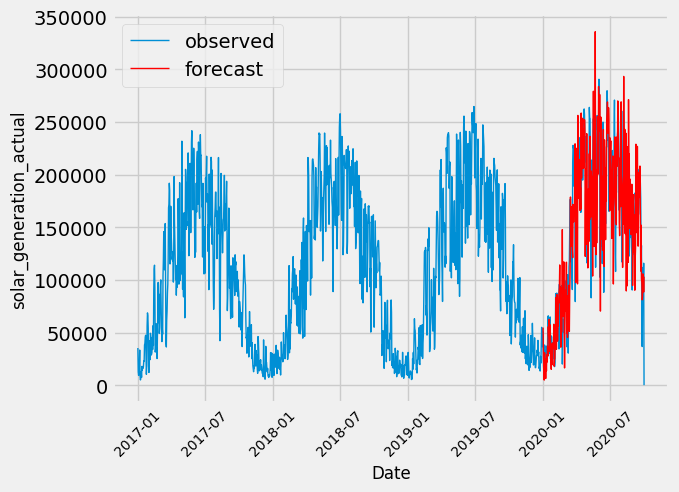

In [75]:
mean_forecast, lower_limits, upper_limits = arima_limits(
    seasonal_results2, 'solar_generation_actual', 274, False
)
arima_plot(solar_ts, mean_forecast, lower_limits, upper_limits)


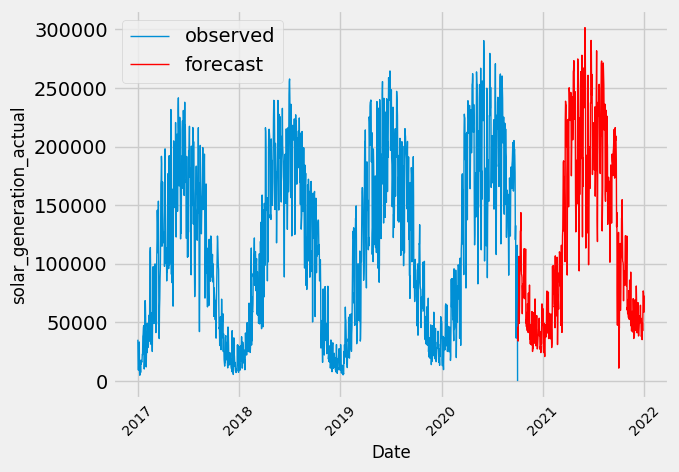

1

In [76]:
seasonal_forecast = seasonal_results2.get_forecast(steps=91+365).predicted_mean

arima_plot_future(solar_ts, seasonal_forecast)

In [657]:
import itertools

In [667]:
p = d = q = range(0, 2)
# pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 365) for x in list(itertools.product(p, d, q))]

for param in [(3,1,3)]:
    for param_seasonal in seasonal_pdq:
        print(param_seasonal)
#         try:
        mod = SARIMAX(solar_ts,
                        order=param,
                        seasonal_order=param_seasonal,
#                             enforce_stationarity=False,
#                             enforce_invertibility=False,
                        simple_differencing=True
                     )
        results = mod.fit()
        print('ARIMA{}x{}365 - AIC:{}'.format(param, param_seasonal, results.aic))
#         except:
#             continue

(0, 0, 0, 365)
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.18539D+01    |proj g|=  2.28494D-01

At iterate    5    f=  1.17564D+01    |proj g|=  3.65760D-02

At iterate   10    f=  1.17536D+01    |proj g|=  2.95222D-03

At iterate   15    f=  1.17531D+01    |proj g|=  2.21020D-02


/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.



At iterate   20    f=  1.17523D+01    |proj g|=  8.07965D-03

At iterate   25    f=  1.17516D+01    |proj g|=  7.54721D-03

At iterate   30    f=  1.17496D+01    |proj g|=  4.20984D-03

At iterate   35    f=  1.17486D+01    |proj g|=  1.33335D-04

At iterate   40    f=  1.17486D+01    |proj g|=  7.98357D-04

At iterate   45    f=  1.17483D+01    |proj g|=  1.68767D-03

At iterate   50    f=  1.17480D+01    |proj g|=  1.96932D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     61      1     0     0   1.969D-03   1.175D+01
  F =   11.748033759998508     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT       

/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible 

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.18539D+01    |proj g|=  2.28494D-01

At iterate    5    f=  1.17557D+01    |proj g|=  3.25260D-02


KeyboardInterrupt: 

In [362]:
import pmdarima as pm

In [686]:
# Create auto_arima model
model1 = pm.auto_arima(solar_ts,
                       start_p=2, max_p=5, 
                       start_q=2, max_q=5, 
                       max_d=2, 
                       start_P=1, max_P=2, 
                       start_Q=1, max_Q=2, 
                       max_D=1, 
                       max_order=5, 
#                        m=365,
                       seasonal=True, 
                       stationary=False, 
                       information_criterion='aic',
                       trace=True
                       
#                       seasonal=True, m=7, # 365
#                       d=0, D=1, 
#                  	  max_p=2, max_q=2,
#                       trace=True,
#                       error_action='ignore',
#                       suppress_warnings=True
                      ) 

# Print model summary
print(model1.summary())

Performing stepwise search to minimize aic


KeyboardInterrupt: 

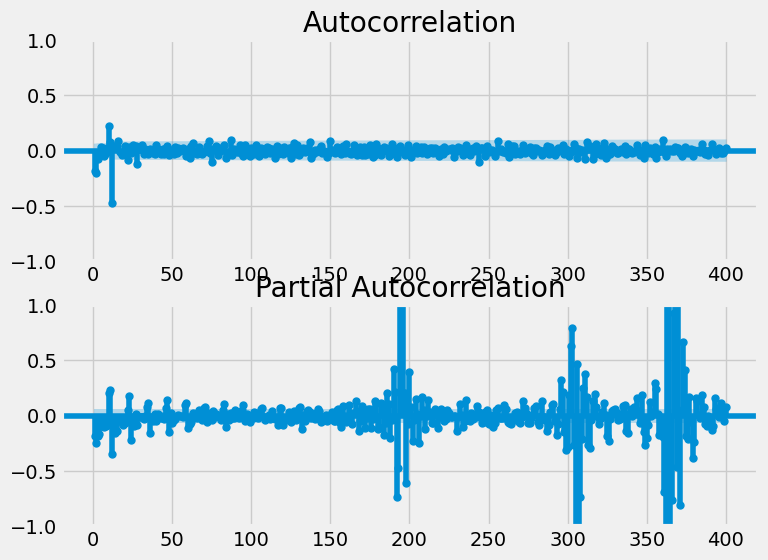

In [367]:
# Take the first and seasonal differences and drop NaNs
solar_ts_diff = solar_ts.diff().diff(365).dropna()

# Create the figure 
fig, (ax1, ax2) = plt.subplots(2,1,figsize=(8,6))
# Plot the ACF on ax1
plot_acf(solar_ts_diff, lags=400, zero=False, ax=ax1)
# Plot the PACF on ax2
plot_pacf(solar_ts_diff, lags=400, zero=False, ax=ax2)

plt.show()


In [ ]:
# # or:

# lags = [12, 24, 36, 48, 60]

# fig, (ax1, ax2) = plt.subplots(2,1,figsize=(8,6))
# # Plot the ACF on ax1
# plot_acf(solar_ts_diff, lags=lags[:5], ax=ax1)
# # Plot the PACF on ax2
# plot_pacf(solar_ts_diff, lags=lags[:5], ax=ax2)

# plt.show()

In [ ]:
# # Create ARIMA mean forecast
# arima_pred = arima_results.get_forecast(steps=25)
# arima_mean = arima_pred.predicted_mean

# # Create SARIMA mean forecast
# sarima_pred = sarima_results.get_forecast(steps=25)
# sarima_mean = sarima_pred.predicted_mean

# # Plot mean ARIMA and SARIMA predictions and observed
# plt.plot(dates, sarima_mean, label='SARIMA', linewidth=1)
# plt.plot(dates, arima_mean, label='ARIMA', linewidth=1)
# # plt.plot(wisconsin_test, label='observed')
# plt.legend()
# plt.show()

In [430]:
gen_decomp = {}

# Get the names of each time series in the DataFrame
gen_names = ger_daily_generation_df_slice.columns

# Run time series decomposition on each time series of the DataFrame
for ts in gen_names:
    ts_decomposition = seasonal_decompose(ger_daily_generation_df_slice[ts])
    gen_decomp[ts] = ts_decomposition

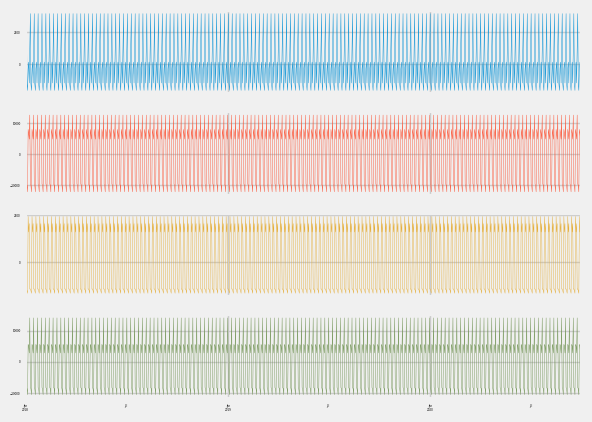

In [431]:
gen_seasonal = {}

# Extract the seasonal values for the decomposition of each time series
for ts in gen_names:
    gen_seasonal[ts] = gen_decomp[ts].seasonal
    
# Create a DataFrame from the jobs_seasonal dictionary
seasonality_df = pd.DataFrame(gen_seasonal)

# Remove the label for the index
seasonality_df.index.name = None

# Create a faceted plot of the seasonality_df DataFrame
seasonality_df.plot(subplots=True,
                   layout=(4,1),
                   sharey=False,
                   fontsize=2,
                   linewidth=0.3,
                   legend=False)
plt.show()

                                 solar_generation_actual  \
solar_generation_actual                         1.000000   
wind_generation_actual                          0.606608   
wind_offshore_generation_actual                 0.356984   
wind_onshore_generation_actual                  0.606608   

                                 wind_generation_actual  \
solar_generation_actual                        0.606608   
wind_generation_actual                         1.000000   
wind_offshore_generation_actual                0.606237   
wind_onshore_generation_actual                 1.000000   

                                 wind_offshore_generation_actual  \
solar_generation_actual                                 0.356984   
wind_generation_actual                                  0.606237   
wind_offshore_generation_actual                         1.000000   
wind_onshore_generation_actual                          0.606237   

                                 wind_onshore_generation_actua

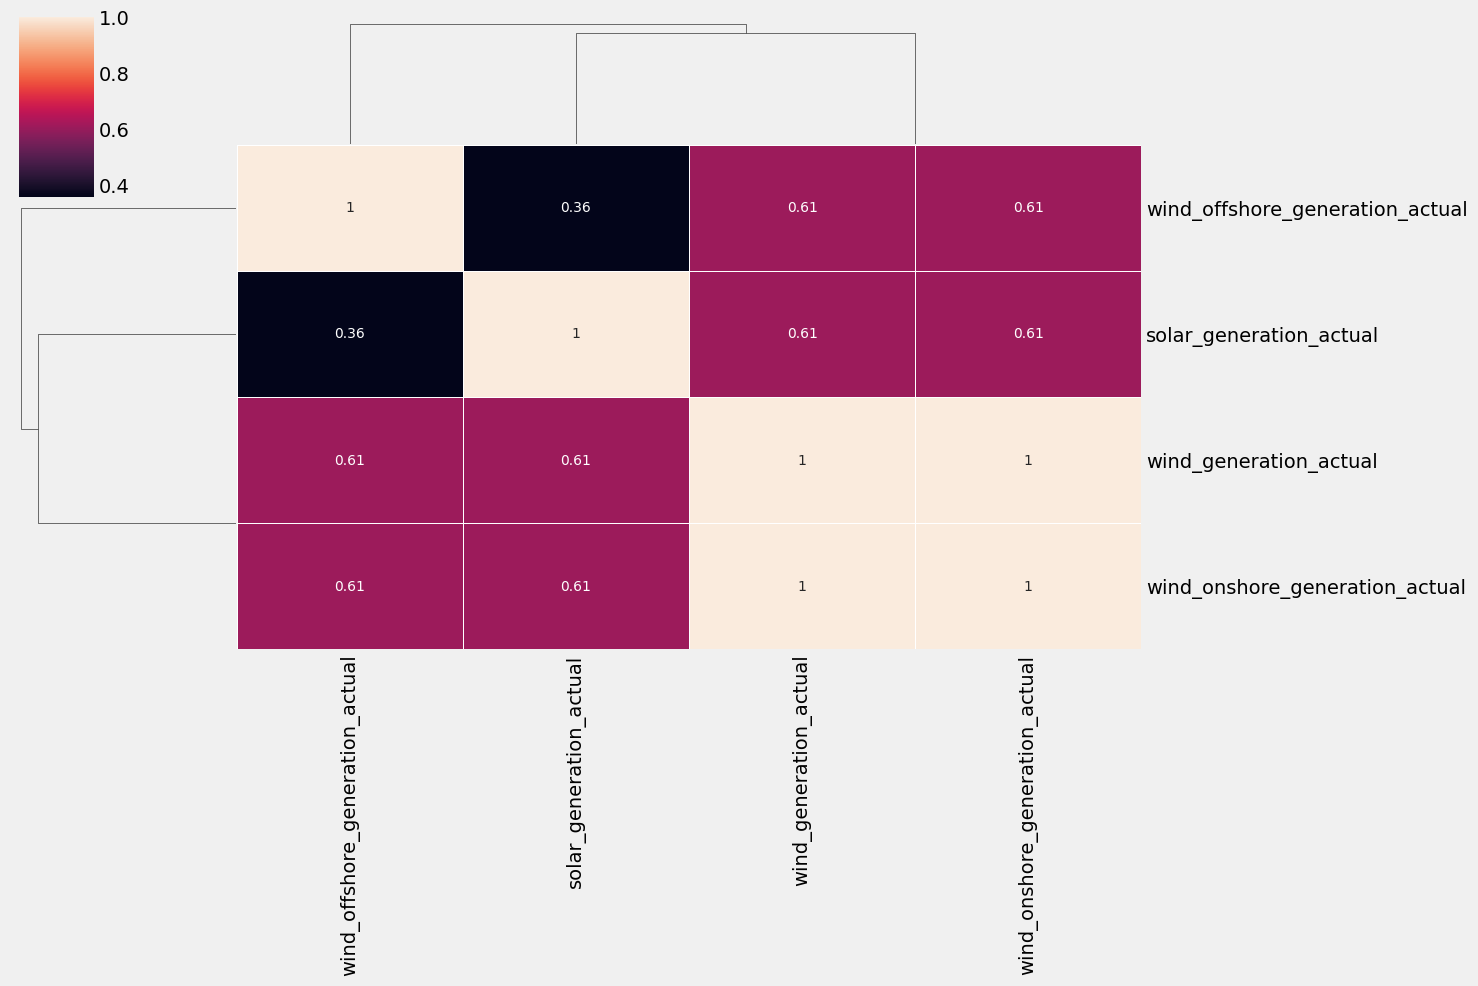

In [381]:
# Get correlation matrix of the seasonality_df DataFrame
seasonality_corr = seasonality_df.corr(method='spearman')
print(seasonality_corr)

# Customize the clustermap of the seasonality_corr correlation matrix
fig = sns.clustermap(seasonality_corr, annot=True, annot_kws={"size": 10}, linewidths=.4, figsize=(15, 10))
plt.setp(fig.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)
plt.setp(fig.ax_heatmap.xaxis.get_majorticklabels(), rotation=90)
plt.show()



<a id="final"></a>

# The End

# ===================== OLD :

In [89]:
# drop percentage columns
# aggregate the generation columns for daily index

ger_df2_agg = ger_df2.drop(pct_columns, axis=1)\
                .groupby(['cet_dt']).max().drop(['cet_cest_timestamp','cet_dttm'], axis=1)
ger_df2_agg.head()

# WHY MAX, NOT SUM ?????

load_actual  load_forecast  solar_capacity  \
cet_dt                                                   
2015-01-01      53672.0        53367.0         37248.0   
2015-01-02      61645.0        57268.0         37250.0   
2015-01-03      56259.0        52963.0         37250.0   
2015-01-04      54108.0        51443.0         37250.0   
2015-01-05      65130.0        60886.0         37252.0   

            solar_generation_actual  wind_capacity  wind_generation_actual  \
cet_dt                                                                       
2015-01-01                   4198.0        27913.0                 22083.0   
2015-01-02                   1899.0        27926.0                 26590.0   
2015-01-03                   1700.0        27926.0                 24076.0   
2015-01-04                   4579.0        27926.0                 19098.0   
2015-01-05                   5870.0        27939.0                 15410.0   

            wind_offshore_capacity  wind_offshore_generation_actual  \
cet_dt                                                                
2015-01-01                   667.0                            528.0   
2015-01-02                   667.0                            512.0   
2015-01-03                   667.0                            516.0   
2015-01-04                   667.0                            514.0   
2015-01-05                   670.0                            474.0   

            wind_onshore_capacity  wind_onshore_generation_actual  
cet_dt                                                             
2015-01-01                27246.0                         21589.0  
2015-01-02                27259.0                         26110.0  
2015-01-03                27259.0                         23567.0  
2015-01-04                27259.0                         18593.0  
2015-01-05                27268.0                         14979.0

In [90]:
ger_df_2015_i = ger_df2_agg.loc[date.fromisoformat('2015-01-01'):date.fromisoformat('2015-03-31')]
ger_df_2015_i

load_actual  load_forecast  solar_capacity  \
cet_dt                                                   
2015-01-01      53672.0        53367.0         37248.0   
2015-01-02      61645.0        57268.0         37250.0   
2015-01-03      56259.0        52963.0         37250.0   
2015-01-04      54108.0        51443.0         37250.0   
2015-01-05      65130.0        60886.0         37252.0   
...                 ...            ...             ...   
2015-03-27      70544.0        68007.0         37481.0   
2015-03-28      56534.0        58553.0         37482.0   
2015-03-29      53514.0        52672.0         37482.0   
2015-03-30      70357.0        69314.0         37494.0   
2015-03-31      71662.0        69673.0         37529.0   

            solar_generation_actual  wind_capacity  wind_generation_actual  \
cet_dt                                                                       
2015-01-01                   4198.0        27913.0                 22083.0   
2015-01-02                   1899.0        27926.0                 26590.0   
2015-01-03                   1700.0        27926.0                 24076.0   
2015-01-04                   4579.0        27926.0                 19098.0   
2015-01-05                   5870.0        27939.0                 15410.0   
...                             ...            ...                     ...   
2015-03-27                  11933.0        28824.0                 13676.0   
2015-03-28                  16359.0        28840.0                 17908.0   
2015-03-29                   5580.0        28845.0                 28000.0   
2015-03-30                  13219.0        28848.0                 23488.0   
2015-03-31                  10605.0        28869.0                 28694.0   

            wind_offshore_capacity  wind_offshore_generation_actual  \
cet_dt                                                                
2015-01-01                   667.0                            528.0   
2015-01-02                   667.0                            512.0   
2015-01-03                   667.0                            516.0   
2015-01-04                   667.0                            514.0   
2015-01-05                   670.0                            474.0   
...                            ...                              ...   
2015-03-27                  1062.0                            750.0   
2015-03-28                  1074.0                           1180.0   
2015-03-29                  1079.0                           1177.0   
2015-03-30                  1079.0                           1181.0   
2015-03-31                  1079.0                           1174.0   

            wind_onshore_capacity  wind_onshore_generation_actual  
cet_dt                                                             
2015-01-01                27246.0                         21589.0  
2015-01-02                27259.0                         26110.0  
2015-01-03                27259.0                         23567.0  
2015-01-04                27259.0                         18593.0  
2015-01-05                27268.0                         14979.0  
...                           ...                             ...  
2015-03-27                27762.0                         13295.0  
2015-03-28                27765.0                         16728.0  
2015-03-29                27765.0                         26951.0  
2015-03-30                27768.0                         22307.0  
2015-03-31                27789.0                         27758.0  

[90 rows x 10 columns]

In [91]:
ger_df2_agg.index

DatetimeIndex(['2015-01-01', '2015-01-02', '2015-01-03', '2015-01-04',
               '2015-01-05', '2015-01-06', '2015-01-07', '2015-01-08',
               '2015-01-09', '2015-01-10',
               ...
               '2020-09-22', '2020-09-23', '2020-09-24', '2020-09-25',
               '2020-09-26', '2020-09-27', '2020-09-28', '2020-09-29',
               '2020-09-30', '2020-10-01'],
              dtype='datetime64[ns]', name='cet_dt', length=2101, freq=None)

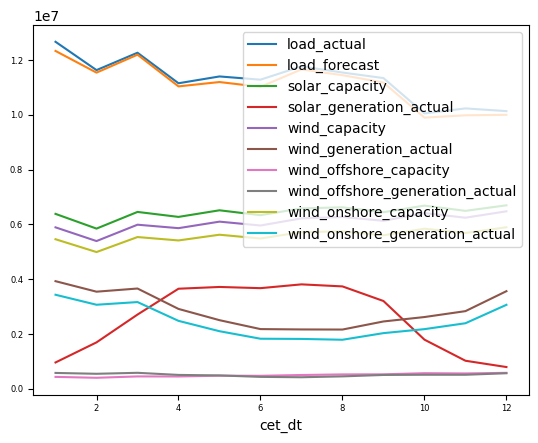

In [97]:

# Get month for each dates in the index
index_month = ger_df2_agg.index.month

# Compute the sum for each month of the year
ger_df2_agg_sum_by_month = ger_df2_agg.groupby(index_month).sum()

# Plot the sum...
ger_df2_agg_sum_by_month.plot(fontsize=6)
plt.legend(fontsize=10, loc='upper right')
plt.show()

<a id="german_plots"></a>

## 1.4. Plots of German dataset

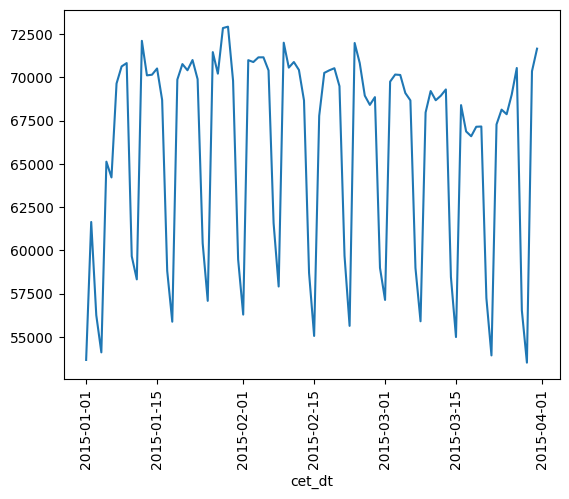

In [29]:
ger_df_2015_i['load_actual'].plot()
plt.xticks(rotation=90)
plt.show()

In [30]:
autocorrelation = ger_df_2015_i['load_actual'].autocorr()
autocorrelation

0.3485310595219947

In [38]:
pd.DataFrame(ger_df_2015_i['load_actual'])

load_actual
cet_dt                 
2015-01-01      53672.0
2015-01-02      61645.0
2015-01-03      56259.0
2015-01-04      54108.0
2015-01-05      65130.0
...                 ...
2015-03-27      70544.0
2015-03-28      56534.0
2015-03-29      53514.0
2015-03-30      70357.0
2015-03-31      71662.0

[90 rows x 1 columns]

In [42]:
# Perform time series decompositon
decomposition_load_actual = seasonal_decompose(pd.DataFrame(ger_df_2015_i['load_actual']).asfreq('D'), model = 'additive')
# asfreq('D') - D = daily

# Print the seasonality component
print(decomposition_load_actual.seasonal)

cet_dt
2015-01-01    3797.345238
2015-01-02    3112.035714
2015-01-03   -7290.904762
2015-01-04   -9879.702381
2015-01-05    3477.821429
                 ...     
2015-03-27    3112.035714
2015-03-28   -7290.904762
2015-03-29   -9879.702381
2015-03-30    3477.821429
2015-03-31    3163.880952
Freq: D, Name: seasonal, Length: 90, dtype: float64


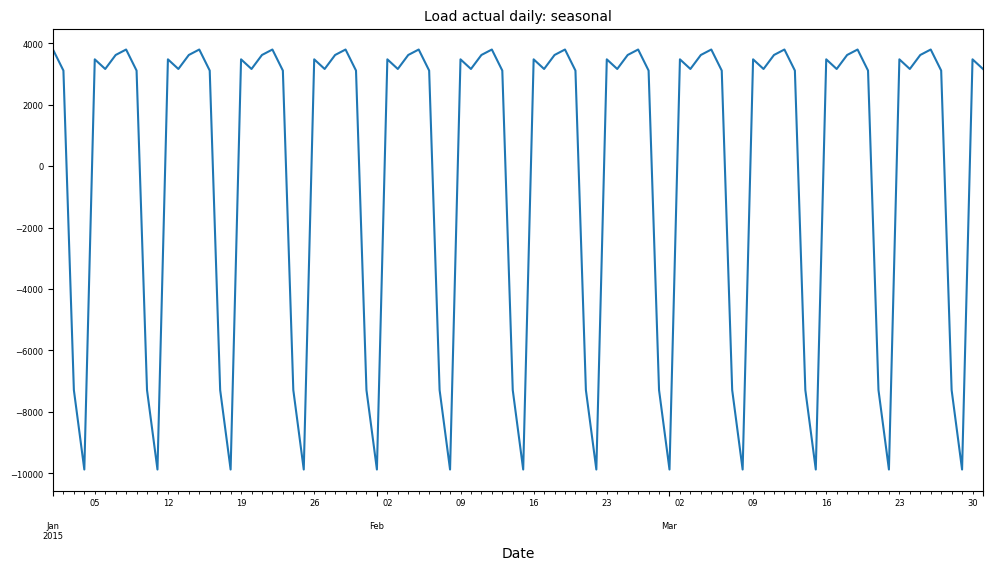

In [46]:
# Extract the seasonal component
seasonal = decomposition_load_actual.seasonal

# Plot the values of the seasonal
ax = seasonal.plot(figsize=(12, 6), fontsize=6)

# Specify axis labels
ax.set_xlabel('Date', fontsize=10)
ax.set_title('Load actual daily: seasonal', fontsize=10)
plt.show()

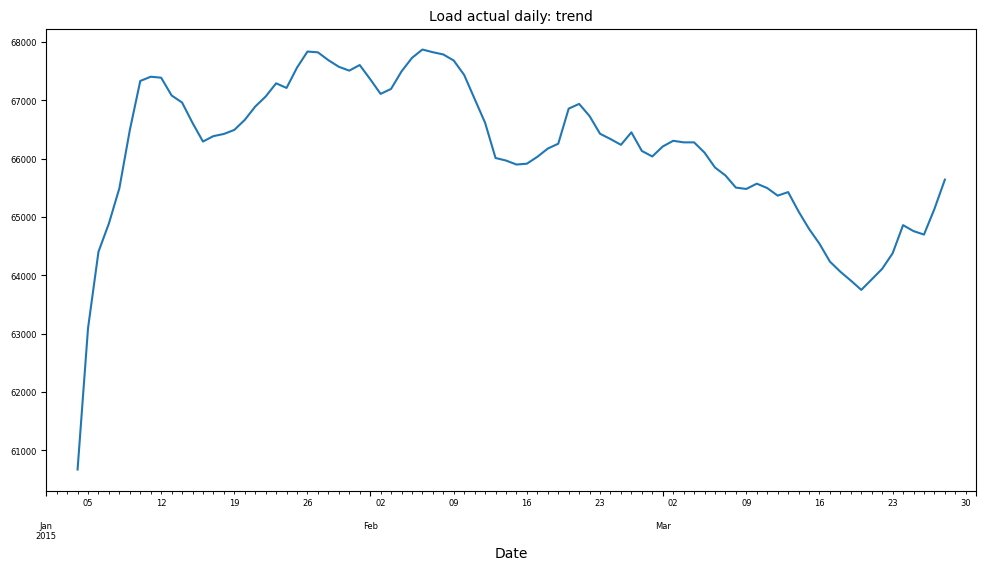

In [44]:
# Extract the trend component
trend = decomposition_load_actual.trend

# Plot the values of the trend
ax = trend.plot(figsize=(12, 6), fontsize=6)

# Specify axis labels
ax.set_xlabel('Date', fontsize=10)
ax.set_title('Load actual daily: trend', fontsize=10)
plt.show()

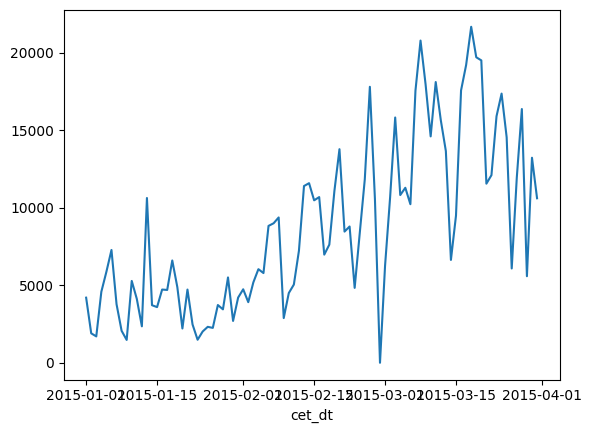

In [31]:
ger_df_2015_i['solar_generation_actual'].plot()
plt.show()

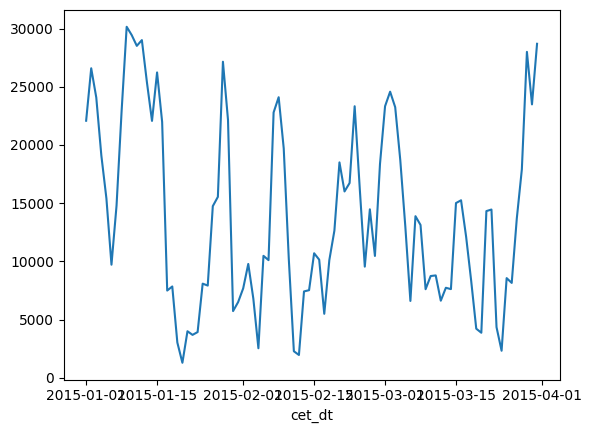

In [32]:
ger_df_2015_i['wind_generation_actual'].plot()
plt.show()

In [91]:
correlation_solar_wind = ger_df_2015_i['solar_generation_actual'].corr(ger_df_2015_i['wind_generation_actual'])
print(correlation_solar_wind)

-0.21745677774954042


In [100]:
ger_df3 = ger_df2_agg[list(ger_df2_agg)]

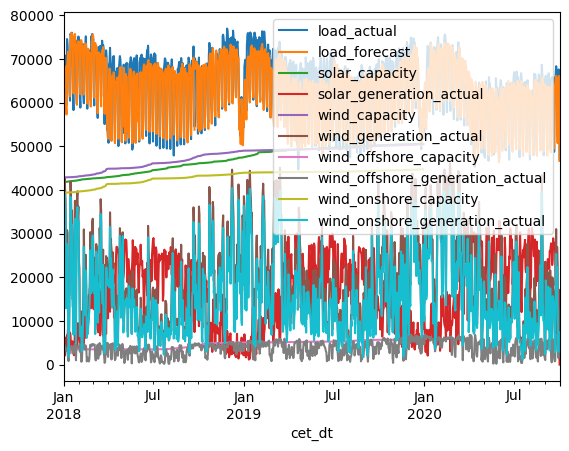

In [103]:
ger_df3_subset_1 = ger_df3['2018':'2020']
ax = ger_df3_subset_1.plot(fontsize=10) # color='blue'
plt.show()

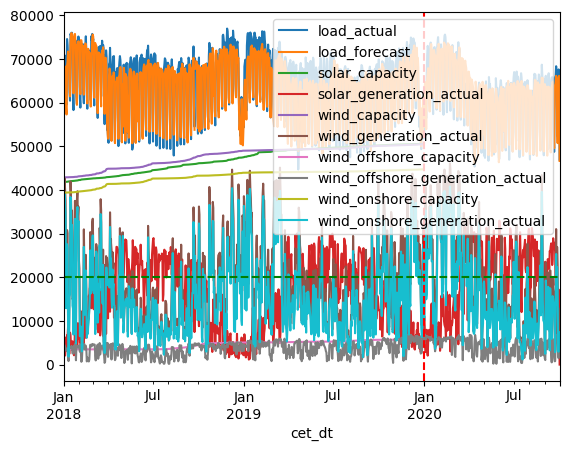

In [104]:
# Plot your the discoveries time series
ax = ger_df3_subset_1.plot(fontsize=10) # color='blue'

# Add a red vertical line
ax.axvline('2020-01-01', color='red', linestyle='--')

# Add a green horizontal line
ax.axhline(20000, color='green', linestyle='--')

plt.show()

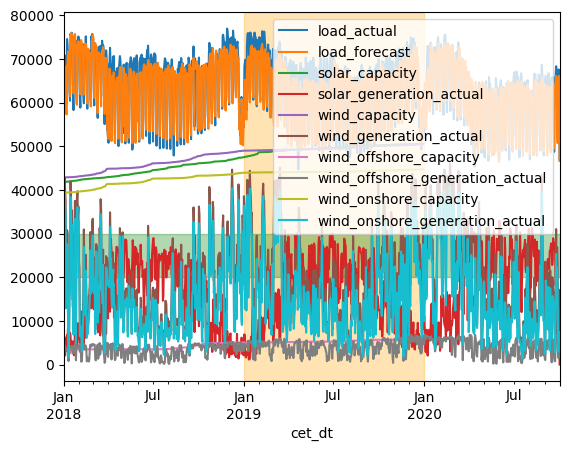

In [105]:
# Plot your the discoveries time series
ax = ger_df3_subset_1.plot(fontsize=10) # color='blue'

# Add a vertical red shaded region
ax.axvspan('2019-01-01', '2020-01-01', color='orange', alpha=0.3)

# Add a horizontal green shaded region
ax.axhspan(20000, 30000, color='green', alpha=0.3)

plt.show()

In [ ]:
'''
https://www.frontiersin.org/articles/10.3389/fenrg.2020.00016/full

(about solar-wind and load)
'''

In [ ]:
# Import joblib
import joblib

# Set model name
filename = "candy_model.pkl"

# Pickle it
joblib.dump(model, filename)